In [1]:
import collections
# Prepare paths to local utilities
import os
import sys
import pickle

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

In [2]:
print(type(tqdm.tqdm()))

0it [00:00, ?it/s]

<class 'tqdm.std.tqdm'>


In [3]:

is_kaggle = (os.environ.get("PWD", "") == "/kaggle/working")
print(f"Are we running in Kaggle? {is_kaggle}")

Are we running in Kaggle? False


In [4]:
if not is_kaggle:
    models_path = os.path.abspath(os.path.join('..', 'model'))
    utils_path = os.path.abspath(os.path.join('..', 'util'))
    sys.path.append(models_path)
    sys.path.append(utils_path)

    %load_ext autoreload
    %autoreload 2

    from download.DataDownloader import DataDownloader
    from collect.DataframeCollector import DataframeCollector
    from collect.TestSetSplitter import TestSetSplitter
    from collect.DatasetPreparation import DatasetPreparation
    from processing.DataPreprocessor import DataPreprocessor
    from reservoir.ThreeHierarchyESNCuda import ThreeHierarchyESNCuda as ThreeHierarchyESN
    from reservoir.ESNUtil import generate_input_weights

else:
    from datadownloader.datadownloader import DataDownloader
    from dataframecollector.dataframecollector import DataframeCollector
    from testsetsplitter.testsetsplitter import TestSetSplitter
    from hierarchyesn.HierarchyESNCuda import HierarchyESNCuda as HierarchyESN
    from esnutil.esnutil import generate_input_weights

In [5]:
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
import contextlib


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    '''
    Context manager to patch joblib to report into tqdm progress bar given as argument
    :param tqdm_object: The tqdm progress bar
    '''

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback

    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [6]:
data_preparation = DatasetPreparation()

input_features = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
output_features = ['label']

data_preparation.prepare_dataset('har70plus', input_features, output_features)

Dataset already downloaded
Discovered  18  csv files in  E:\PyCharm\COM6906-Dissertation\data\har70plus
Loading the csv files into dataframes
Loaded  18  dataframes
Concatenating the dataframes
Data shape:  [(103860, 9), (131367, 9), (116413, 9), (150758, 9), (87006, 9), (122714, 9), (120125, 9), (130494, 9), (121763, 9), (122061, 9), (128063, 9), (119310, 9), (123599, 9), (101510, 9), (153517, 9), (138278, 9), (147045, 9), (141714, 9)]
Number of frames in training set: 17
Number of frames in validation set: 17
Number of frames in testing set: 18
X_train shape: (1357646, 6), Y_train shape: (1357646,)
X_val shape: (339404, 6), Y_val shape: (339404,)
X_test shape: (562547, 6), Y_test shape: (562547,)
Y_train encoded shape: (1357646, 7)
Y_val encoded shape: (339404, 7)
Y_test encoded shape: (562547, 7)
Y_train decoded shape: (1357646, 1)
Y_val decoded shape: (339404, 1)
Y_test decoded shape: (562547, 1)
X_train scaled shape: (1357646, 6)
X_val scaled shape: (339404, 6)
X_test scaled shape

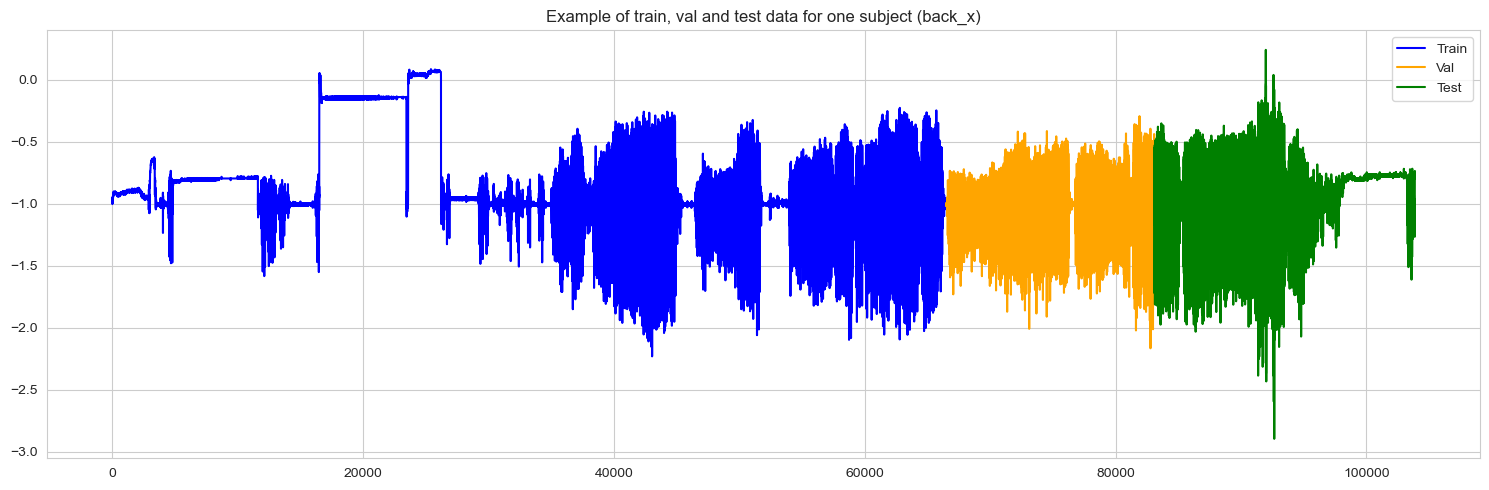

In [7]:
# Lets plot the data on a graph, colouring by whether it is train, val or test data
# Plot the column for back_x

train_set, val_set, test_set = data_preparation.get_sets()

plt.figure(figsize=(15, 5))

plt.plot(train_set[0]['back_x'], label='Train', color='blue')
plt.plot(val_set[0]['back_x'], label='Val', color='orange')
plt.plot(test_set[0]['back_x'], label='Test', color='green')
plt.legend()

plt.title(f'Example of train, val and test data for one subject (back_x)')
plt.tight_layout()
plt.show()

In [8]:
# Now we need to create the ESN

# We can star by defining the input weights for the data

# We will initially start by drawing on the best hyperparameters from the previous experiments
# To recap, the best hyperparameters were:
# Best Neurons 1: 400, Best Neurons 2: 100
# Best Density 1: 0.7983216917715843, Best Density 2: 0.010877135881297934
# Best Leakage Rate 1: 0.9318915931720418, Best Leakage Rate 2: 0.35101073644620073
# Best Spectral Radius 1: 0.9819903553570943, Best Spectral Radius 2: 0.1404437385565157
# Best Gamma 1: 0.9634809164294149, Best Gamma 2: 0.7797466776214464
# Best Weight Distribution 1: uniform, Best Weight Distribution 2: 0/1
# As we have two reservoirs, we will define the first reservoir the same as with the previous experiments
#  and the second reservoir will have slightly boosted values than the previous experiments as we now have a third reservoir

# To do this, we will create a matrix of shape (n_neurons, n_features) where n_neurons is the number of neurons in the reservoir and n_features is the number of features in the input signal
# We will then populate this matrix from a density function where elements are 1 for a value p, and 0 for a value of 1-p
# This will give us a sparse matrix with a density of p

n_features = 6
density_1 = 0.7983216917715843
density_2 = 0.30
density_3 = 0.010877135881297934

weight_distribution_1 = 'uniform'
weight_distribution_2 = '0/1'
weight_distribution_3 = 'uniform'

# To keep things consistent, we will keep the total number of neurons the same as the previous experiments, so 500 total
# To begin with, we will split this evenly between the two reservoirs
n_neurons_1 = 300
n_neurons_2 = 100
n_neurons_3 = 100

# Generate the input weights
input_weights_1 = generate_input_weights(n_neurons_1, n_features, density_1, weight_distribution_1, seed=42)

# Check the shape of the input weights
print(f'Res1 Input weights shape: {input_weights_1.shape}')

input_weights_2 = generate_input_weights(n_neurons_2, n_features, density_2, weight_distribution_2, seed=42)

# Check the shape of the input weights
print(f'Res2 Input weights shape: {input_weights_2.shape}')

input_weights_3 = generate_input_weights(n_neurons_3, n_features, density_3, weight_distribution_3, seed=42)

# Check the shape of the input weights
print(f'Res3 Input weights shape: {input_weights_3.shape}')

# Next, we initialise the ESN

class_weights = data_preparation.get_class_weights()

leakage_rate_1 = 0.9318915931720418
spectral_radius_1 = 0.9819903553570943
gamma_1 = 0.9634809164294149
W_in_1 = input_weights_1
sparsity_1 = 0.8

leakage_rate_2 = 0.55101073644620073  # Slightly boosted leakage rate for the second reservoir as we now have a third reservoir
spectral_radius_2 = 0.3404437385565157  # Slightly boosted spectral radius for the second reservoir
gamma_2 = 0.8797466776214464  # Slightly boosted gamma for the second reservoir
W_in_2 = input_weights_2
sparsity_2 = 0.5

leakage_rate_3 = 0.35101073644620073  # The hyperparameters from the previous second reservoir
spectral_radius_3 = 0.1404437385565157
gamma_3 = 0.7797466776214464
W_in_3 = input_weights_3
sparsity_3 = 0.25

Res1 Input weights shape: (300, 6)
Res2 Input weights shape: (100, 6)
Res3 Input weights shape: (100, 6)


In [9]:
esn = ThreeHierarchyESN(leakage_rate_1=leakage_rate_1, spectral_radius_1=spectral_radius_1, gamma_1=gamma_1,
                        W_in_1=W_in_1,
                        n_neurons_1=n_neurons_1, sparsity_1=sparsity_1,
                        leakage_rate_2=leakage_rate_2, spectral_radius_2=spectral_radius_2, gamma_2=gamma_2,
                        W_in_2=W_in_2,
                        n_neurons_2=n_neurons_2, sparsity_2=sparsity_2,
                        leakage_rate_3=leakage_rate_3, spectral_radius_3=spectral_radius_3, gamma_3=gamma_3,
                        W_in_3=W_in_3,
                        n_neurons_3=n_neurons_3, sparsity_3=sparsity_3,
                        class_weights=class_weights, seed=42)
# Now we need to train the ESN
# We will train the ESN using the training data

X_train_scaled, y_train_encoded = data_preparation.get_preprocessed_data('train')
X_val_scaled, y_val_encoded = data_preparation.get_preprocessed_data('val')
X_test_scaled, y_test_encoded = data_preparation.get_preprocessed_data('test')

# As a test, lets only take the first 1000 samples
n_samples = 500000
data_in = X_train_scaled
data_out = y_train_encoded

[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9318915931720418, spectral_radius_1: 0.9819903553570943, gamma_1: 0.9634809164294149, n_neurons_1: 300, leakage_rate_2: 0.5510107364462007, spectral_radius_2: 0.3404437385565157, gamma_2: 0.8797466776214464, n_neurons_2: 100 and leakage_rate_3: 0.35101073644620073, spectral_radius_3: 0.1404437385565157, gamma_3: 0.7797466776214464, n_neurons_3: 100


In [10]:
baseline_pickle = 'threeHierarchyESN_har70_baseline.pkl'

# If a pickle file exists for this baseline, we will load the ESN from the pickle file instead of training it
if not os.path.exists(baseline_pickle):
    esn.fit(data_in, data_out, x_val=X_val_scaled, y_val=y_val_encoded)

    # Save the ESN to a pickle file
    with open(baseline_pickle, 'wb') as f:
        pickle.dump(esn, f)
else:
    # Load the ESN from the pickle file
    with open(baseline_pickle, 'rb') as f:
        esn = pickle.load(f)

# Now we can use the ESN to predict the output for the test data
y_pred = esn.forward(X_test_scaled)

Step: 0/1357646
Step: 10000/1357646
Step: 20000/1357646
Step: 30000/1357646
Step: 40000/1357646
Step: 50000/1357646
Step: 60000/1357646
Step: 70000/1357646
Step: 80000/1357646
Step: 90000/1357646
Step: 100000/1357646
Step: 110000/1357646
Step: 120000/1357646
Step: 130000/1357646
Step: 140000/1357646
Step: 150000/1357646
Step: 160000/1357646
Step: 170000/1357646
Step: 180000/1357646
Step: 190000/1357646
Step: 200000/1357646
Step: 210000/1357646
Step: 220000/1357646
Step: 230000/1357646
Step: 240000/1357646
Step: 250000/1357646
Step: 260000/1357646
Step: 270000/1357646
Step: 280000/1357646
Step: 290000/1357646
Step: 300000/1357646
Step: 310000/1357646
Step: 320000/1357646
Step: 330000/1357646
Step: 340000/1357646
Step: 350000/1357646
Step: 360000/1357646
Step: 370000/1357646
Step: 380000/1357646
Step: 390000/1357646
Step: 400000/1357646
Step: 410000/1357646
Step: 420000/1357646
Step: 430000/1357646
Step: 440000/1357646
Step: 450000/1357646
Step: 460000/1357646
Step: 470000/1357646
Step: 

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.69427e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.25496199179100365
Alpha: 16.681005372000556, Score: 0.20220251764879885
Alpha: 129.15496650148827, Score: 0.14591296380566549
Alpha: 1000.0, Score: 0.10598476200662872
Best alpha: 0.004641588833612777
Readout layer fitted.
Step: 0/562547
Step: 10000/562547
Step: 20000/562547
Step: 30000/562547
Step: 40000/562547
Step: 50000/562547
Step: 60000/562547
Step: 70000/562547
Step: 80000/562547
Step: 90000/562547
Step: 100000/562547
Step: 110000/562547
Step: 120000/562547
Step: 130000/562547
Step: 140000/562547
Step: 150000/562547
Step: 160000/562547
Step: 170000/562547
Step: 180000/562547
Step: 190000/562547
Step: 200000/562547
Step: 210000/562547
Step: 220000/562547
Step: 230000/562547
Step: 240000/562547
Step: 250000/562547
Step: 260000/562547
Step: 270000/562547
Step: 280000/562547
Step: 290000/562547
Step: 300000/562547
Step: 310000/562547
Step: 320000/562547
Step: 330000/562547
Step: 340000/562547
Step: 350000/562547
Step: 360000/562547
Step: 370000/562

In [11]:
# Check the shape of the predicted output
y_pred.shape

(562547, 7)

In [12]:
# Get the first few rows of the predicted output
y_pred[:5]

array([[ 3.7036505 , -5.048168  , -1.5490303 ,  4.907347  ,  2.037838  ,
        -0.9790964 , -2.0723467 ],
       [ 6.113324  , -6.4293327 , -2.157051  ,  6.148936  , -0.4582491 ,
         1.8951302 , -4.1125383 ],
       [ 6.175332  , -6.8949356 , -2.5371666 ,  7.9852777 , -1.2848711 ,
         0.7819195 , -3.2252111 ],
       [ 6.079076  , -5.9992447 , -2.5692558 ,  8.077768  , -2.0320368 ,
         0.02432632, -2.580327  ],
       [ 5.999776  , -4.745941  , -2.1086235 ,  6.7058587 , -2.2904482 ,
        -0.54582596, -2.0143347 ]], dtype=float32)

In [13]:
# The predicted output is a one-hot encoded array, so we need to decode it back to the original labels
y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred)

# Check the shape of the decoded output
y_pred_decoded.shape

(562547, 1)

In [14]:
# Get the first few rows of the decoded output
y_pred_decoded[:5]

array([[5],
       [5],
       [5],
       [5],
       [5]], dtype=int64)

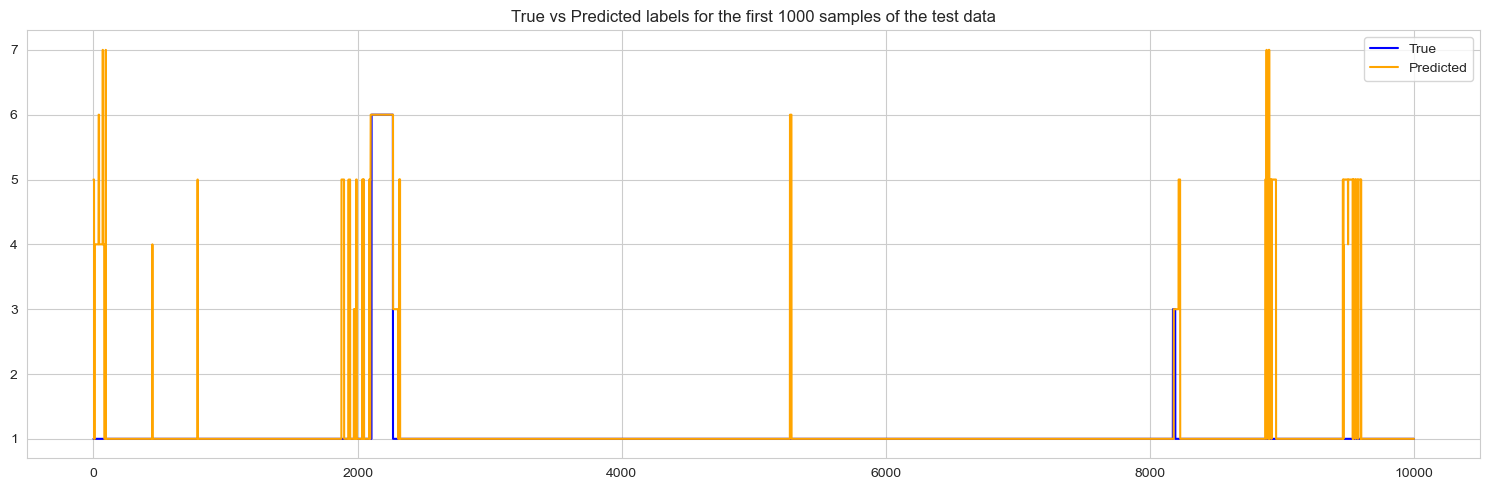

In [15]:
# Now we can evaluate the accuracy of the ESN on the test data
# Start by plotting the true label and the predicted label on a graph

y_test_decoded = data_preparation.get_decoded_labels('test')

plt.figure(figsize=(15, 5))
plt.plot(y_test_decoded[:10000], label='True', color='blue')
plt.plot(y_pred_decoded[:10000], label='Predicted', color='orange')
plt.legend()
plt.title('True vs Predicted labels for the first 1000 samples of the test data')

plt.tight_layout()
plt.show()

In [16]:
# Now we can calculate the accuracy of the ESN on the test data
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_decoded, y_pred_decoded)

accuracy

0.7468904820397229

In [17]:
# Now we can calculate the confusion matrix for the ESN on the test data
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

conf_matrix

array([[253764,  48161,   4829,  25402,  14384,     34,      7],
       [   465,  12422,    188,   3170,   3372,     23,      0],
       [   322,    225,   1734,    360,     67,      0,      0],
       [    34,     86,      2,    248,      0,      0,      0],
       [   726,  33999,     52,   4597, 102412,     10,      0],
       [    20,      7,    155,   1681,      2,  41339,      0],
       [     0,      0,      0,      6,      0,      0,   8242]],
      dtype=int64)

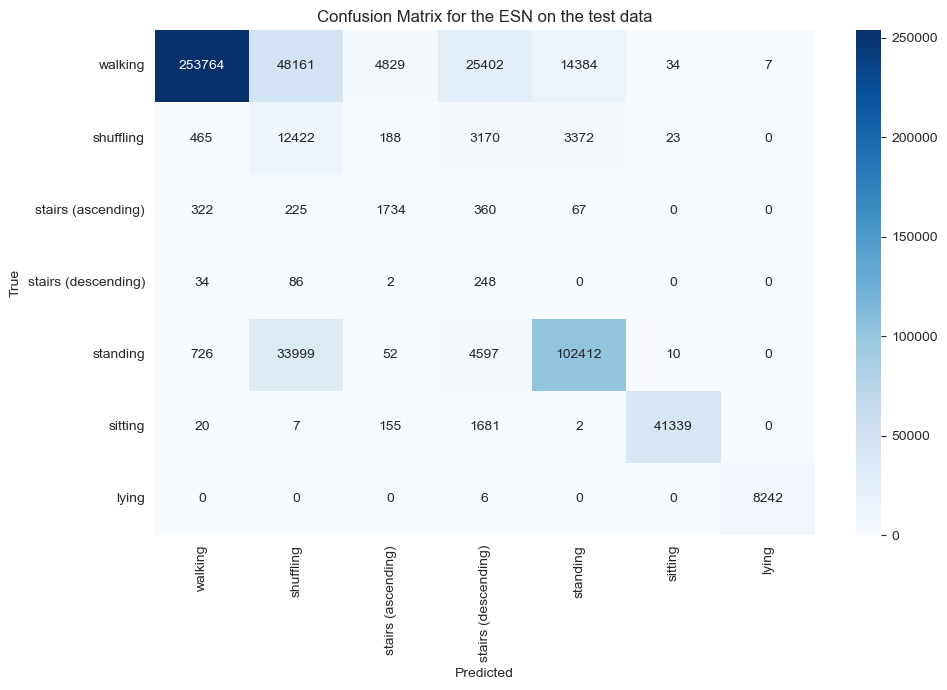

In [18]:
# Now we can plot the confusion matrix
# Our labels are 
# 1: walking	
# 3: shuffling
# 4: stairs (ascending)
# 5: stairs (descending)
# 6: standing
# 7: sitting
# 8: lying
# So we will use these labels for the x and y axis of the confusion matrix
import seaborn as sns

labels = ['walking', 'shuffling', 'stairs (ascending)', 'stairs (descending)', 'standing', 'sitting', 'lying']

plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Confusion Matrix for the ESN on the test data')

plt.tight_layout()
plt.show()

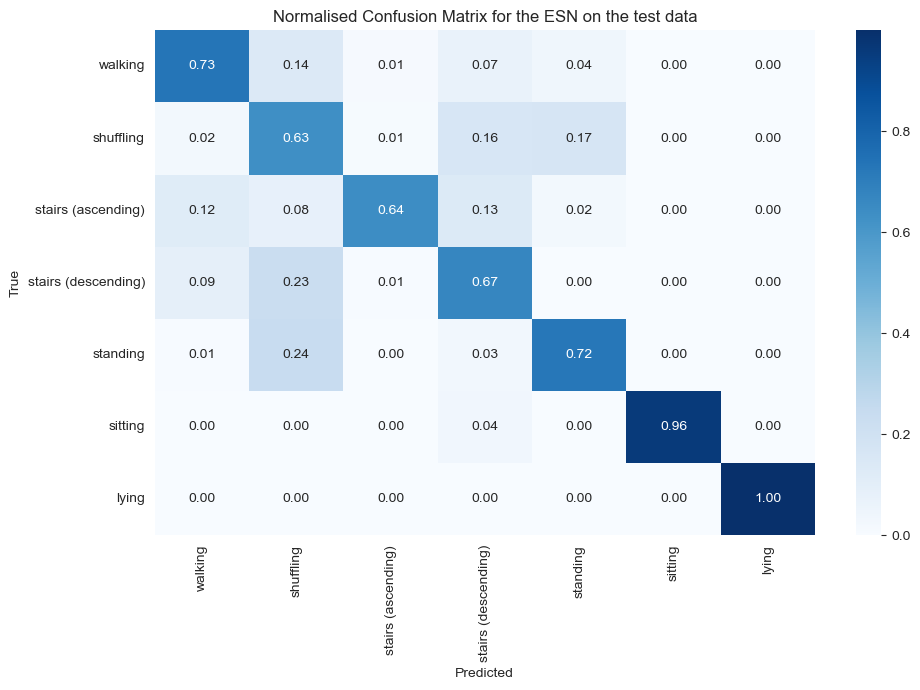

In [19]:
# Let's print a normalised confusion matrix as there is a class imbalance
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Normalised Confusion Matrix for the ESN on the test data')

plt.tight_layout()
plt.show()

In [20]:
# Now we can calculate the precision, recall and f1-score for the ESN on the test data
from sklearn.metrics import classification_report

report = classification_report(y_test_decoded, y_pred_decoded, target_names=labels)

print(report)

                     precision    recall  f1-score   support

            walking       0.99      0.73      0.84    346581
          shuffling       0.13      0.63      0.22     19640
 stairs (ascending)       0.25      0.64      0.36      2708
stairs (descending)       0.01      0.67      0.01       370
           standing       0.85      0.72      0.78    141796
            sitting       1.00      0.96      0.98     43204
              lying       1.00      1.00      1.00      8248

           accuracy                           0.75    562547
          macro avg       0.60      0.76      0.60    562547
       weighted avg       0.92      0.75      0.82    562547



In [25]:
# We can see that this is already performing quite well with the two reservoirs using different hyperparameters
# Let's try and optimise this further by using hyperopt to find the best hyperparameters for the ESN
# We will start by defining the hyperparameter space
from hyperopt import hp
from sklearn.metrics import mean_squared_error

total_neurons = 500

weight_distribution_options = ['uniform', 'normal', '0/1', '-1/1']

space = {
    'leakage_rate_1': hp.uniform('leakage_rate_1', 0.8, 1),
    'spectral_radius_1': hp.uniform('spectral_radius_1', 0.8, 1),
    'gamma_1': hp.uniform('gamma_1', 0.8, 1),
    'density_1': hp.uniform('density_1', 0.6, 1),
    'sparsity_1': hp.uniform('sparsity_1', 0, 1),

    'leakage_rate_2': hp.uniform('leakage_rate_2', 0, 1),
    'spectral_radius_2': hp.uniform('spectral_radius_2', 0, 1),
    'gamma_2': hp.uniform('gamma_2', 0, 1),
    'density_2': hp.uniform('density_2', 0, 1),
    'sparsity_2': hp.uniform('sparsity_2', 0, 1),

    'leakage_rate_3': hp.uniform('leakage_rate_3', 0, 1),
    'spectral_radius_3': hp.uniform('spectral_radius_3', 0, 1),
    'gamma_3': hp.uniform('gamma_3', 0, 1),
    'density_3': hp.uniform('density_3', 0, 1),
    'sparsity_3': hp.uniform('sparsity_3', 0, 1),

    # The number of neurons should be between 100 and 500, and n_neurons_1 + n_neurons_2 = 500
    # The upper bound is set to the total - 100 to ensure that each reservoir has at least 100 neurons
    'n_neurons_1': hp.quniform('n_neurons_1', 250, 350, 1),
    # The ratio of neurons in the second reservoir compared to the third out of (total - n_neurons_1)
    'n_neurons_2_ratio': hp.uniform('n_neurons_2_ratio', 0.2, 0.8),

    'weight_distribution_1': hp.choice('weight_distribution_1', weight_distribution_options),
    'weight_distribution_2': hp.choice('weight_distribution_2', weight_distribution_options),
    'weight_distribution_3': hp.choice('weight_distribution_3', weight_distribution_options),
}

In [29]:
# We will also define the objective function
from hyperopt import STATUS_OK


def objective(params):
    # Generate the input weights
    n_features = 6

    n_neurons_1 = int(params['n_neurons_1'])
    n_neurons_2_ratio = params['n_neurons_2_ratio']
    remaining_neurons = total_neurons - n_neurons_1
    n_neurons_2 = int(n_neurons_2_ratio * remaining_neurons)
    n_neurons_3 = int(remaining_neurons - n_neurons_2)

    print(f'n_neurons_1: {n_neurons_1}, n_neurons_2: {n_neurons_2}, n_neurons_3: {n_neurons_3}')

    input_weights_1 = generate_input_weights(n_neurons_1, n_features, params['density_1'],
                                             params['weight_distribution_1'], seed=42)
    input_weights_2 = generate_input_weights(n_neurons_2, n_features, params['density_2'],
                                             params['weight_distribution_2'], seed=42)
    input_weights_3 = generate_input_weights(n_neurons_3, n_features, params['density_3'],
                                             params['weight_distribution_3'], seed=42)

    # Create the ESN
    esn = ThreeHierarchyESN(leakage_rate_1=params['leakage_rate_1'], spectral_radius_1=params['spectral_radius_1'],
                            gamma_1=params['gamma_1'], W_in_1=input_weights_1, n_neurons_1=n_neurons_1,
                            sparsity_1=params['sparsity_1'],
                            leakage_rate_2=params['leakage_rate_2'], spectral_radius_2=params['spectral_radius_2'],
                            gamma_2=params['gamma_2'], W_in_2=input_weights_2, n_neurons_2=n_neurons_2,
                            sparsity_2=params['sparsity_2'],
                            leakage_rate_3=params['leakage_rate_3'], spectral_radius_3=params['spectral_radius_3'],
                            gamma_3=params['gamma_3'], W_in_3=input_weights_3, n_neurons_3=n_neurons_3,
                            sparsity_3=params['sparsity_3'],
                            class_weights=class_weights, seed=42, is_optimising=True)

    # Fit the ESN
    esn.fit(data_in, data_out, x_val=X_val_scaled, y_val=y_val_encoded)

    # Predict the output
    y_pred = esn.forward(X_test_scaled)

    # Decode the output
    y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred)

    # Calculate the nmrse
    nmrse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (y_pred_decoded.max() - y_pred_decoded.min())

    return {'loss': nmrse, 'status': STATUS_OK}

In [30]:
run_hierarchy_optimisation = False

In [31]:
# Now we can run the hyperparameter optimisation
if run_hierarchy_optimisation:
    from hyperopt import fmin, tpe, Trials

    n_iterations = 30

    trials = Trials()

    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=n_iterations, trials=trials)

else:
    best = {'density_1': 0.8098222387059135, 'density_2': 0.750474862642194, 'density_3': 0.7438124394609645,
            'gamma_1': 0.8008014185674769, 'gamma_2': 0.1906404433300536, 'gamma_3': 0.4754788170338825,
            'leakage_rate_1': 0.9721196221438391, 'leakage_rate_2': 0.5610244981317168,
            'leakage_rate_3': 0.6674647243532564, 'n_neurons_1': 350.0, 'n_neurons_2_ratio': 0.22459944549893424,
            'sparsity_1': 0.302371243155928, 'sparsity_2': 0.23013225478870247, 'sparsity_3': 0.8292750282111857,
            'spectral_radius_1': 0.9048794207552125, 'spectral_radius_2': 0.0532568977054132,
            'spectral_radius_3': 0.13303480091978592, 'weight_distribution_1': 0, 'weight_distribution_2': 0,
            'weight_distribution_3': 2}

n_neurons_1: 288, n_neurons_2: 96, n_neurons_3: 116   
[]                                                    
Is CUDA available: True                               
HierarchyESN initialised with leakage_rate_1: 0.805919357543894, spectral_radius_1: 0.9809354814570295, gamma_1: 0.986432377238313, n_neurons_1: 288, leakage_rate_2: 0.8447511153767152, spectral_radius_2: 0.5063986928033272, gamma_2: 0.7920390946146866, n_neurons_2: 96 and leakage_rate_3: 0.11811244883094962, spectral_radius_3: 0.2346186677256391, gamma_3: 0.15101362425653342, n_neurons_3: 116
Step: 0/1357646                                       

Step: 10000/1357646                                   

Step: 20000/1357646                                   

Step: 30000/1357646                                   

Step: 40000/1357646                                   

Step: 50000/1357646                                   

Step: 60000/1357646                                   

Step: 70000/1357646                           

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.88697e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 0.2782559402207126, Score: 0.1734572028868173  
Alpha: 2.154434690031882, Score: 0.13832216999839259  
Alpha: 16.681005372000556, Score: 0.10612431721319401 
Alpha: 129.15496650148827, Score: 0.07410800293033468 
Alpha: 1000.0, Score: 0.06086970880956571             
Best alpha: 0.004641588833612777                      
Readout layer fitted.                                 
Step: 0/562547                                        

Step: 10000/562547                                    

Step: 20000/562547                                    

Step: 30000/562547                                    

Step: 40000/562547                                    

Step: 50000/562547                                    

Step: 60000/562547                                    

Step: 70000/562547                                    

Step: 80000/562547                                    

Step: 90000/562547                                    

Step: 100000/562547                                   


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.3053e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 0.2782559402207126, Score: 0.16732665277236305                                 
Alpha: 2.154434690031882, Score: 0.1340798613559482                                   
Alpha: 16.681005372000556, Score: 0.10114096637865781                                 
Alpha: 129.15496650148827, Score: 0.06169922269914084                                 
Alpha: 1000.0, Score: 0.03272578257697884                                             
Best alpha: 0.0005994842503189409                                                     
Readout layer fitted.                                                                 
Step: 0/562547                                                                        

Step: 10000/562547                                                                    

Step: 20000/562547                                                                    

Step: 30000/562547                                                                    

Step: 40000/562547                     

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.34588e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 2.154434690031882, Score: 0.2601375751610283                                     
Alpha: 16.681005372000556, Score: 0.21735043805398963                                   
Alpha: 129.15496650148827, Score: 0.15891980302591632                                   
Alpha: 1000.0, Score: 0.11218140288264707                                               
Best alpha: 0.03593813663804626                                                         
Readout layer fitted.                                                                   
Step: 0/562547                                                                          

Step: 10000/562547                                                                      

Step: 20000/562547                                                                      

Step: 30000/562547                                                                      

Step: 40000/562547                                                                      

Step: 50000/5625

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.31655e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 2.154434690031882, Score: 0.2560661345346956                                     
Alpha: 16.681005372000556, Score: 0.21780294336892012                                   
Alpha: 129.15496650148827, Score: 0.1680968340502016                                    
Alpha: 1000.0, Score: 0.1169098711311634                                                
Best alpha: 0.004641588833612777                                                        
Readout layer fitted.                                                                   
Step: 0/562547                                                                          

Step: 10000/562547                                                                      

Step: 20000/562547                                                                      

Step: 30000/562547                                                                      

Step: 40000/562547                                                                      

Step: 50000/5625

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.77404e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 0.2782559402207126, Score: 0.22344224972247964                                   
Alpha: 2.154434690031882, Score: 0.18824897332742735                                    
Alpha: 16.681005372000556, Score: 0.1518393125672566                                    
Alpha: 129.15496650148827, Score: 0.10422593650820865                                   
Alpha: 1000.0, Score: 0.06901865931630459                                               
Best alpha: 1e-05                                                                       
Readout layer fitted.                                                                   
Step: 0/562547                                                                          

Step: 10000/562547                                                                      

Step: 20000/562547                                                                      

Step: 30000/562547                                                                      

Step: 40000/56254

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.71011e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 2.154434690031882, Score: 0.23120832984745623                                    
Alpha: 16.681005372000556, Score: 0.17648390277507278                                   
Alpha: 129.15496650148827, Score: 0.125720781080159                                     
Alpha: 1000.0, Score: 0.09455138937744957                                               
Best alpha: 0.0005994842503189409                                                       
Readout layer fitted.                                                                   
Step: 0/562547                                                                          

Step: 10000/562547                                                                      

Step: 20000/562547                                                                      

Step: 30000/562547                                                                      

Step: 40000/562547                                                                      

Step: 50000/5625

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.73179e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 0.2782559402207126, Score: 0.19772889122558765                                   
Alpha: 2.154434690031882, Score: 0.16618635091368233                                    
Alpha: 16.681005372000556, Score: 0.1266613428610563                                    
Alpha: 129.15496650148827, Score: 0.08479916301544378                                   
Alpha: 1000.0, Score: 0.05319188888089992                                               
Best alpha: 0.0005994842503189409                                                       
Readout layer fitted.                                                                   
Step: 0/562547                                                                          

Step: 10000/562547                                                                      

Step: 20000/562547                                                                      

Step: 30000/562547                                                                      

Step: 40000/56254

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.34268e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 2.154434690031882, Score: 0.24063379120476855                                    
Alpha: 16.681005372000556, Score: 0.1962681043405252                                    
Alpha: 129.15496650148827, Score: 0.14919086918244925                                   
Alpha: 1000.0, Score: 0.10966787369545827                                               
Best alpha: 0.0005994842503189409                                                       
Readout layer fitted.                                                                   
Step: 0/562547                                                                          

Step: 10000/562547                                                                      

Step: 20000/562547                                                                      

Step: 30000/562547                                                                      

Step: 40000/562547                                                                      

Step: 50000/5625

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.38736e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 0.2782559402207126, Score: 0.16652238608848974                                   
Alpha: 2.154434690031882, Score: 0.1458131861465148                                     
Alpha: 16.681005372000556, Score: 0.1210216374372655                                    
Alpha: 129.15496650148827, Score: 0.05665648398217206                                   
Alpha: 1000.0, Score: 0.0030351191538408834                                             
Best alpha: 7.742636826811278e-05                                                       
Readout layer fitted.                                                                   
Step: 0/562547                                                                          

Step: 10000/562547                                                                      

Step: 20000/562547                                                                      

Step: 30000/562547                                                                      

Step: 40000/56254

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.1056e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 2.154434690031882, Score: 0.2725780275334434                                     
Alpha: 16.681005372000556, Score: 0.24203701605996647                                   
Alpha: 129.15496650148827, Score: 0.1903876218525875                                    
Alpha: 1000.0, Score: 0.1285458223232894                                                
Best alpha: 0.03593813663804626                                                         
Readout layer fitted.                                                                   
Step: 0/562547                                                                          

Step: 10000/562547                                                                      

Step: 20000/562547                                                                      

Step: 30000/562547                                                                      

Step: 40000/562547                                                                      

Step: 50000/5625

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.73143e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 0.2782559402207126, Score: 0.2054330639043294                                    
Alpha: 2.154434690031882, Score: 0.1657938554989856                                     
Alpha: 16.681005372000556, Score: 0.12518352935068458                                   
Alpha: 129.15496650148827, Score: 0.08793341690489546                                   
Alpha: 1000.0, Score: 0.06484128185612904                                               
Best alpha: 0.0005994842503189409                                                       
Readout layer fitted.                                                                   
Step: 0/562547                                                                          

Step: 10000/562547                                                                      

Step: 20000/562547                                                                      

Step: 30000/562547                                                                      

Step: 40000/56254

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.17092e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 0.2782559402207126, Score: 0.16926695448255583                                   
Alpha: 2.154434690031882, Score: 0.14251107105709995                                    
Alpha: 16.681005372000556, Score: 0.11203034242221124                                   
Alpha: 129.15496650148827, Score: 0.06381278060525783                                   
Alpha: 1000.0, Score: 0.02832224434129203                                               
Best alpha: 7.742636826811278e-05                                                       
Readout layer fitted.                                                                   
Step: 0/562547                                                                          

Step: 10000/562547                                                                      

Step: 20000/562547                                                                      

Step: 30000/562547                                                                      

Step: 40000/56254

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.5377e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 0.2782559402207126, Score: 0.12193735136084828                                   
Alpha: 2.154434690031882, Score: 0.08384692453313396                                    
Alpha: 16.681005372000556, Score: 0.04015729654557513                                   
Alpha: 129.15496650148827, Score: -0.000760844945301201                                 
Alpha: 1000.0, Score: -0.019398374847548108                                             
Best alpha: 0.0005994842503189409                                                       
Readout layer fitted.                                                                   
Step: 0/562547                                                                          

Step: 10000/562547                                                                      

Step: 20000/562547                                                                      

Step: 30000/562547                                                                      

Step: 40000/56254

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.63446e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 2.154434690031882, Score: 0.2420367385672441                                     
Alpha: 16.681005372000556, Score: 0.1951197137908764                                    
Alpha: 129.15496650148827, Score: 0.14427045738355165                                   
Alpha: 1000.0, Score: 0.10001552160922376                                               
Best alpha: 0.004641588833612777                                                        
Readout layer fitted.                                                                   
Step: 0/562547                                                                          

Step: 10000/562547                                                                      

Step: 20000/562547                                                                      

Step: 30000/562547                                                                      

Step: 40000/562547                                                                      

Step: 50000/5625

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.63386e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 0.2782559402207126, Score: 0.23137436761639993                                   
Alpha: 2.154434690031882, Score: 0.1901909510326496                                     
Alpha: 16.681005372000556, Score: 0.13956033127760165                                   
Alpha: 129.15496650148827, Score: 0.09908597974681733                                   
Alpha: 1000.0, Score: 0.07451323916470912                                               
Best alpha: 0.004641588833612777                                                        
Readout layer fitted.                                                                   
Step: 0/562547                                                                          

Step: 10000/562547                                                                      

Step: 20000/562547                                                                      

Step: 30000/562547                                                                      

Step: 40000/56254

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.97275e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 2.154434690031882, Score: 0.2382427144037125                                     
Alpha: 16.681005372000556, Score: 0.18066571558900385                                   
Alpha: 129.15496650148827, Score: 0.12467339671170616                                   
Alpha: 1000.0, Score: 0.0951395616433033                                                
Best alpha: 0.03593813663804626                                                         
Readout layer fitted.                                                                   
Step: 0/562547                                                                          

Step: 10000/562547                                                                      

Step: 20000/562547                                                                      

Step: 30000/562547                                                                      

Step: 40000/562547                                                                      

Step: 50000/5625

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.84001e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 2.154434690031882, Score: 0.24604407278111287
Alpha: 16.681005372000556, Score: 0.19173021957180517                                   
Alpha: 129.15496650148827, Score: 0.1320205868793751                                    
Alpha: 1000.0, Score: 0.09607738329569869                                               
Best alpha: 0.004641588833612777                                                        
Readout layer fitted.                                                                   
Step: 0/562547                                                                          

Step: 10000/562547                                                                      

Step: 20000/562547                                                                      

Step: 30000/562547                                                                      

Step: 40000/562547                                                                      

Step: 50000/562547                                  

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.58658e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 2.154434690031882, Score: 0.13341607307099598                                     
Alpha: 16.681005372000556, Score: 0.1440249359353433                                     
Alpha: 129.15496650148827, Score: 0.12676401139674714                                    
Alpha: 1000.0, Score: 0.09841070495216345                                                
Best alpha: 16.681005372000556                                                           
Readout layer fitted.                                                                    
Step: 0/562547                                                                           

Step: 10000/562547                                                                       

Step: 20000/562547                                                                       

Step: 30000/562547                                                                       

Step: 40000/562547                                                                       

Step:

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.40231e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 2.154434690031882, Score: 0.10655174388030417                                     
Alpha: 16.681005372000556, Score: 0.14134846904805673                                    
Alpha: 129.15496650148827, Score: 0.12817283646447783                                    
Alpha: 1000.0, Score: 0.09311040933926128                                                
Best alpha: 16.681005372000556                                                           
Readout layer fitted.                                                                    
Step: 0/562547                                                                           

Step: 10000/562547                                                                       

Step: 20000/562547                                                                       

Step: 30000/562547                                                                       

Step: 40000/562547                                                                       

Step:

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.79225e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 2.154434690031882, Score: 0.2593121612894556                                      
Alpha: 16.681005372000556, Score: 0.2247620323852961                                     
Alpha: 129.15496650148827, Score: 0.17272038979586574                                    
Alpha: 1000.0, Score: 0.11794984938267314                                                
Best alpha: 0.03593813663804626                                                          
Readout layer fitted.                                                                    
Step: 0/562547                                                                           

Step: 10000/562547                                                                       

Step: 20000/562547                                                                       

Step: 30000/562547                                                                       

Step: 40000/562547                                                                       

Step:

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.88726e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 2.154434690031882, Score: 0.24787762306131064                                     
Alpha: 16.681005372000556, Score: 0.19481955619054878                                    
Alpha: 129.15496650148827, Score: 0.1332751470376714                                     
Alpha: 1000.0, Score: 0.09637381760958964                                                
Best alpha: 0.2782559402207126                                                           
Readout layer fitted.                                                                    
Step: 0/562547                                                                           

Step: 10000/562547                                                                       

Step: 20000/562547                                                                       

Step: 30000/562547                                                                       

Step: 40000/562547                                                                       

Step:

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.26322e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 2.154434690031882, Score: 0.2561910399780936                                      
Alpha: 16.681005372000556, Score: 0.214740779897339                                      
Alpha: 129.15496650148827, Score: 0.15764199107997603                                    
Alpha: 1000.0, Score: 0.11073251771929885                                                
Best alpha: 0.03593813663804626                                                          
Readout layer fitted.                                                                    
Step: 0/562547                                                                           

Step: 10000/562547                                                                       

Step: 20000/562547                                                                       

Step: 30000/562547                                                                       

Step: 40000/562547                                                                       

Step:

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.95869e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 2.154434690031882, Score: 0.2536662115243667                                      
Alpha: 16.681005372000556, Score: 0.1991523465183958                                     
Alpha: 129.15496650148827, Score: 0.13804740355673775                                    
Alpha: 1000.0, Score: 0.10388565015476633                                                
Best alpha: 0.03593813663804626                                                          
Readout layer fitted.                                                                    
Step: 0/562547                                                                           

Step: 10000/562547                                                                       

Step: 20000/562547                                                                       

Step: 30000/562547                                                                       

Step: 40000/562547                                                                       

Step:

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.1236e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 2.154434690031882, Score: 0.2636040633551578                                      
Alpha: 16.681005372000556, Score: 0.21750487855216097                                    
Alpha: 129.15496650148827, Score: 0.15489885121070163                                    
Alpha: 1000.0, Score: 0.10542032878356493                                                
Best alpha: 0.03593813663804626                                                          
Readout layer fitted.                                                                    
Step: 0/562547                                                                           

Step: 10000/562547                                                                       

Step: 20000/562547                                                                       

Step: 30000/562547                                                                       

Step: 40000/562547                                                                       

Step:

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.37106e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 2.154434690031882, Score: 0.24814651571705454                                     
Alpha: 16.681005372000556, Score: 0.1924182704229673                                     
Alpha: 129.15496650148827, Score: 0.13483405768003126                                    
Alpha: 1000.0, Score: 0.10295463927819619                                                
Best alpha: 0.2782559402207126                                                           
Readout layer fitted.                                                                    
Step: 0/562547                                                                           

Step: 10000/562547                                                                       

Step: 20000/562547                                                                       

Step: 30000/562547                                                                       

Step: 40000/562547                                                                       

Step:

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.35221e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Alpha: 2.154434690031882, Score: 0.23920904961043782                                   
Alpha: 16.681005372000556, Score: 0.18255539682454208                                  
Alpha: 129.15496650148827, Score: 0.12612034605046152                                  
Alpha: 1000.0, Score: 0.09627064246510049                                              
Best alpha: 0.004641588833612777                                                       
Readout layer fitted.                                                                  
Step: 0/562547                                                                         

Step: 10000/562547                                                                     

Step: 20000/562547                                                                     

Step: 30000/562547                                                                     

Step: 40000/562547                                                                     

Step: 50000/562547         

In [32]:
print(best)

{'density_1': 0.8098222387059135, 'density_2': 0.750474862642194, 'density_3': 0.7438124394609645, 'gamma_1': 0.8008014185674769, 'gamma_2': 0.1906404433300536, 'gamma_3': 0.4754788170338825, 'leakage_rate_1': 0.9721196221438391, 'leakage_rate_2': 0.5610244981317168, 'leakage_rate_3': 0.6674647243532564, 'n_neurons_1': 350.0, 'n_neurons_2_ratio': 0.22459944549893424, 'sparsity_1': 0.302371243155928, 'sparsity_2': 0.23013225478870247, 'sparsity_3': 0.8292750282111857, 'spectral_radius_1': 0.9048794207552125, 'spectral_radius_2': 0.0532568977054132, 'spectral_radius_3': 0.13303480091978592, 'weight_distribution_1': 0, 'weight_distribution_2': 0, 'weight_distribution_3': 2}


In [35]:
# Let's get the best hyperparameters
best_leakage_rate_1 = best['leakage_rate_1']
best_spectral_radius_1 = best['spectral_radius_1']
best_gamma_1 = best['gamma_1']
best_density_1 = best['density_1']
best_sparsity_1 = best['sparsity_1']

best_leakage_rate_2 = best['leakage_rate_2']
best_spectral_radius_2 = best['spectral_radius_2']
best_gamma_2 = best['gamma_2']
best_density_2 = best['density_2']
best_sparsity_2 = best['sparsity_2']

best_leakage_rate_3 = best['leakage_rate_3']
best_spectral_radius_3 = best['spectral_radius_3']
best_gamma_3 = best['gamma_3']
best_density_3 = best['density_3']
best_sparsity_3 = best['sparsity_3']

neuron_opts = [100, 200, 300, 400]

best_n_neurons_1 = int(best['n_neurons_1'])
best_n_neurons_2_ratio = best['n_neurons_2_ratio']
best_n_neurons_2 = int(best_n_neurons_2_ratio * (total_neurons - best_n_neurons_1))
best_n_neurons_3 = int(total_neurons - best_n_neurons_1 - best_n_neurons_2)

best_weight_distribution_1 = weight_distribution_options[best['weight_distribution_1']]
best_weight_distribution_2 = weight_distribution_options[best['weight_distribution_2']]
best_weight_distribution_3 = weight_distribution_options[best['weight_distribution_3']]

print(f'Best Neurons 1: {best_n_neurons_1}, Best Neurons 2: {best_n_neurons_2}, Best Neurons 3: {best_n_neurons_3}')
print(f'Best Density 1: {best_density_1}, Best Density 2: {best_density_2}, Best Density 3: {best_density_3}')
print(
    f'Best Leakage Rate 1: {best_leakage_rate_1}, Best Leakage Rate 2: {best_leakage_rate_2}, Best Leakage Rate 3: {best_leakage_rate_3}')
print(
    f'Best Spectral Radius 1: {best_spectral_radius_1}, Best Spectral Radius 2: {best_spectral_radius_2}, Best Spectral Radius 3: {best_spectral_radius_3}')
print(f'Best Gamma 1: {best_gamma_1}, Best Gamma 2: {best_gamma_2}, Best Gamma 3: {best_gamma_3}')
print(
    f'Best Weight Distribution 1: {best_weight_distribution_1}, Best Weight Distribution 2: {best_weight_distribution_2}, Best Weight Distribution 3: {best_weight_distribution_3}')
print(f'Best Sparsity 1: {best_sparsity_1}, Best Sparsity 2: {best_sparsity_2}, Best Sparsity 3: {best_sparsity_3}')

Best Neurons 1: 350, Best Neurons 2: 33, Best Neurons 3: 117
Best Density 1: 0.8098222387059135, Best Density 2: 0.750474862642194, Best Density 3: 0.7438124394609645
Best Leakage Rate 1: 0.9721196221438391, Best Leakage Rate 2: 0.5610244981317168, Best Leakage Rate 3: 0.6674647243532564
Best Spectral Radius 1: 0.9048794207552125, Best Spectral Radius 2: 0.0532568977054132, Best Spectral Radius 3: 0.13303480091978592
Best Gamma 1: 0.8008014185674769, Best Gamma 2: 0.1906404433300536, Best Gamma 3: 0.4754788170338825
Best Weight Distribution 1: uniform, Best Weight Distribution 2: uniform, Best Weight Distribution 3: 0/1
Best Sparsity 1: 0.302371243155928, Best Sparsity 2: 0.23013225478870247, Best Sparsity 3: 0.8292750282111857


In [36]:
# Now we can create the ESN with the best hyperparameters
# If we are running the optimisation, or the pickle file does not exist, we will create the ESN with the best hyperparameters
# Otherwise, we will load the ESN from the pickle file

optimised_pickle = 'threeHierarchyESN_har70_optimised.pkl'

if run_hierarchy_optimisation or not os.path.exists(optimised_pickle):
    input_weights_1 = generate_input_weights(best_n_neurons_1, n_features, best_density_1, best_weight_distribution_1,
                                             seed=42)
    input_weights_2 = generate_input_weights(best_n_neurons_2, n_features, best_density_2, best_weight_distribution_2,
                                             seed=42)
    input_weights_3 = generate_input_weights(best_n_neurons_3, n_features, best_density_3, best_weight_distribution_3,
                                             seed=42)

    esn = ThreeHierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                            gamma_1=best_gamma_1,
                            W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1, sparsity_1=best_sparsity_1,
                            leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                            gamma_2=best_gamma_2,
                            W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2, sparsity_2=best_sparsity_2,
                            leakage_rate_3=best_leakage_rate_3, spectral_radius_3=best_spectral_radius_3,
                            gamma_3=best_gamma_3,
                            W_in_3=input_weights_3, n_neurons_3=best_n_neurons_3, sparsity_3=best_sparsity_3,
                            class_weights=class_weights, seed=42)

    # Fit the ESN
    esn.fit(data_in, data_out, x_val=X_val_scaled, y_val=y_val_encoded)

    # Let's also pickle the best ESN for future use
    with open(optimised_pickle, 'wb') as f:
        pickle.dump(esn, f)

else:
    # Load the ESN from the pickle file
    with open(optimised_pickle, 'rb') as f:
        esn = pickle.load(f)

# Predict the output
y_pred = esn.forward(X_test_scaled)

# Decode the output
y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred)

# Calculate the nmrse
nmrse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (y_pred_decoded.max() - y_pred_decoded.min())

print(f'Optimised NMRSE: {nmrse}')

[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 0.6674647243532564, spectral_radius_3: 0.13303480091978592, gamma_3: 0.4754788170338825, n_neurons_3: 117
Step: 0/1357646
Step: 10000/1357646
Step: 20000/1357646
Step: 30000/1357646
Step: 40000/1357646
Step: 50000/1357646
Step: 60000/1357646
Step: 70000/1357646
Step: 80000/1357646
Step: 90000/1357646
Step: 100000/1357646
Step: 110000/1357646
Step: 120000/1357646
Step: 130000/1357646
Step: 140000/1357646
Step: 150000/1357646
Step: 160000/1357646
Step: 170000/1357646
Step: 180000/1357646
Step: 190000/1357646
Step: 200000/1357646
Step: 210000/1357646
Step: 220000/1357646
Step: 230000/1357646
Step: 240000/1357646
Step: 250000/1357646
Step: 260000/1357646
Step: 270000/1357646
S

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.97275e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.2382427144037125
Alpha: 16.681005372000556, Score: 0.18066571558900385
Alpha: 129.15496650148827, Score: 0.12467339671170616
Alpha: 1000.0, Score: 0.0951395616433033
Best alpha: 0.03593813663804626
Readout layer fitted.
Step: 0/562547
Step: 10000/562547
Step: 20000/562547
Step: 30000/562547
Step: 40000/562547
Step: 50000/562547
Step: 60000/562547
Step: 70000/562547
Step: 80000/562547
Step: 90000/562547
Step: 100000/562547
Step: 110000/562547
Step: 120000/562547
Step: 130000/562547
Step: 140000/562547
Step: 150000/562547
Step: 160000/562547
Step: 170000/562547
Step: 180000/562547
Step: 190000/562547
Step: 200000/562547
Step: 210000/562547
Step: 220000/562547
Step: 230000/562547
Step: 240000/562547
Step: 250000/562547
Step: 260000/562547
Step: 270000/562547
Step: 280000/562547
Step: 290000/562547
Step: 300000/562547
Step: 310000/562547
Step: 320000/562547
Step: 330000/562547
Step: 340000/562547
Step: 350000/562547
Step: 360000/562547
Step: 370000/562547

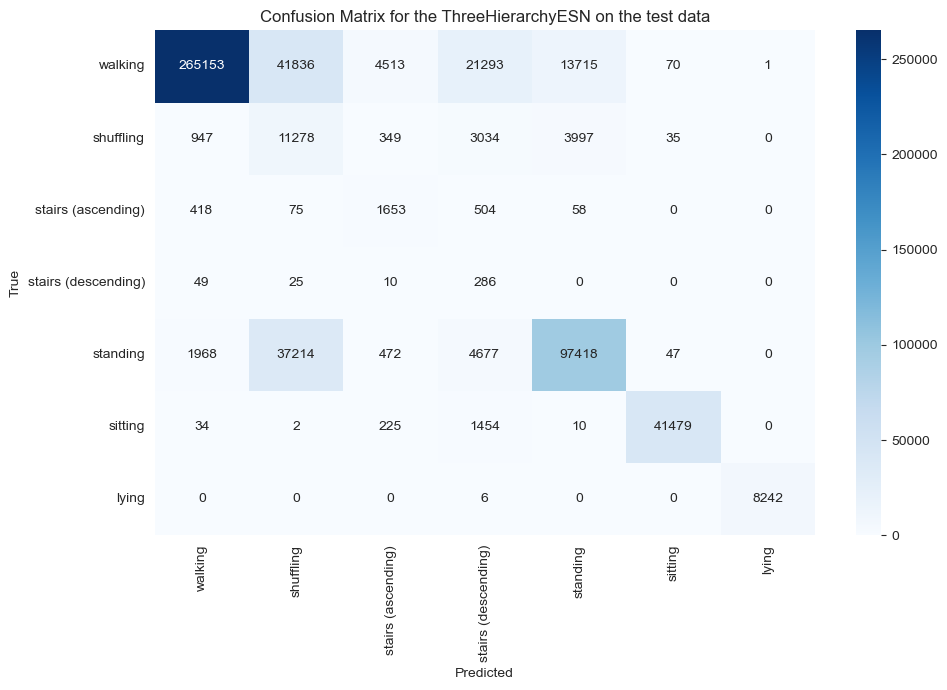

In [37]:
# Let's plot the confusion matrix for the best ESN
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Confusion Matrix for the ThreeHierarchyESN on the test data')

plt.tight_layout()
plt.show()

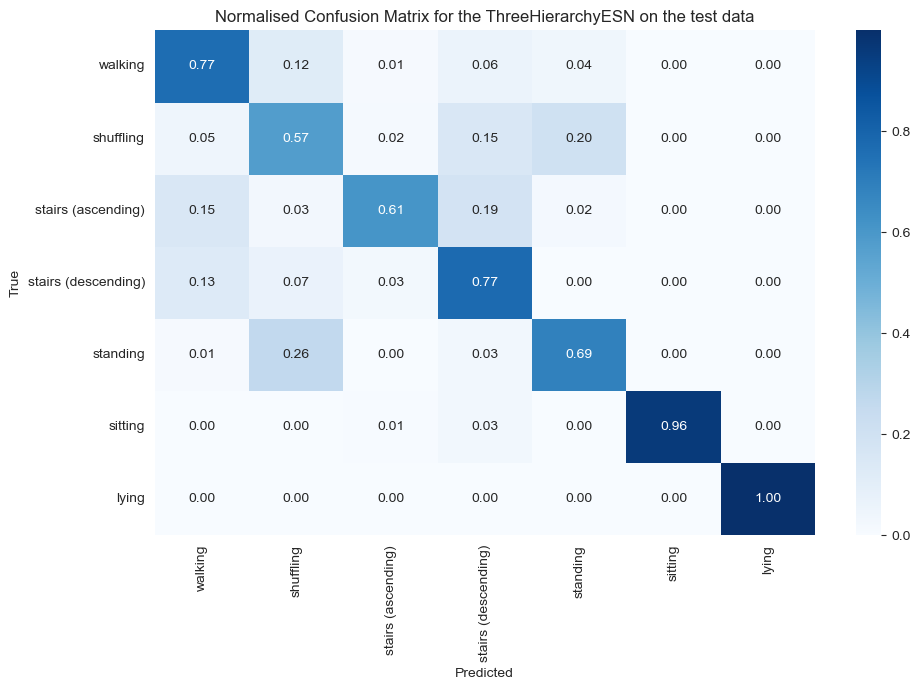

In [38]:
# Let's plot the normalised confusion matrix for the best ESN
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Normalised Confusion Matrix for the ThreeHierarchyESN on the test data')

plt.tight_layout()
plt.show()

In [39]:
# Let's print the classification report for the best ESN
report = classification_report(y_test_decoded, y_pred_decoded, target_names=labels)

print(report)

                     precision    recall  f1-score   support

            walking       0.99      0.77      0.86    346581
          shuffling       0.12      0.57      0.20     19640
 stairs (ascending)       0.23      0.61      0.33      2708
stairs (descending)       0.01      0.77      0.02       370
           standing       0.85      0.69      0.76    141796
            sitting       1.00      0.96      0.98     43204
              lying       1.00      1.00      1.00      8248

           accuracy                           0.76    562547
          macro avg       0.60      0.77      0.59    562547
       weighted avg       0.92      0.76      0.82    562547



In [40]:
# Let's also try applying some of the preprocessing techniques used in prior experiments to see if we can improve the performance of the ESN further
data_preprocessor = DataPreprocessor()

# The data preprocessor object provides access to different data preprocessing methods
# The available methods are:
# - buffered_windows(window_size, x, y)
# - exponential_moving_average(alpha, x, y)
# - fourier_smoothing(x, threshold)
# - pipeline(step_names, x, y)
# - get_available_steps()

In [41]:
run_window_optimisation = False

In [42]:
# Let's start by applying the buffered windows method to the data
# For these experiments, we will use the previously found best hyperparameters above

window_sizes = [10, 50, 100, 500]

window_scores = []

if run_window_optimisation:
    for window_size in window_sizes:
        print(f'Window Size: {window_size}')
        X_train_windowed, y_train_windowed = data_preprocessor.buffered_windows(window_size, X_train_scaled,
                                                                                y_train_encoded)
        X_val_windowed, y_val_windowed = data_preprocessor.buffered_windows(window_size, X_val_scaled, y_val_encoded)
        X_test_windowed, y_test_windowed = data_preprocessor.buffered_windows(window_size, X_test_scaled,
                                                                              y_test_encoded)

        # As the windowed data is now in a different shape, we need to regenerate the input weights
        input_weights_1 = generate_input_weights(best_n_neurons_1, X_train_windowed.shape[1], best_density_1,
                                                 best_weight_distribution_1,
                                                 seed=42)
        input_weights_2 = generate_input_weights(best_n_neurons_2, X_train_windowed.shape[1], best_density_2,
                                                 best_weight_distribution_2,
                                                 seed=42)
        input_weights_3 = generate_input_weights(best_n_neurons_3, X_train_windowed.shape[1], best_density_3,
                                                 best_weight_distribution_3,
                                                 seed=42)

        esn = ThreeHierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                                gamma_1=best_gamma_1,
                                W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1, sparsity_1=best_sparsity_1,
                                leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                                gamma_2=best_gamma_2,
                                W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2, sparsity_2=best_sparsity_2,
                                leakage_rate_3=best_leakage_rate_3, spectral_radius_3=best_spectral_radius_3,
                                gamma_3=best_gamma_3,
                                W_in_3=input_weights_3, n_neurons_3=best_n_neurons_3, sparsity_3=best_sparsity_3,
                                class_weights=class_weights, seed=42)

        # Fit the ESN
        esn.fit(X_train_windowed, y_train_windowed, x_val=X_val_windowed, y_val=y_val_windowed)

        # Predict the output
        y_pred = esn.forward(X_test_windowed)

        # Decode the output
        # We need to decode the output as it is one-hot encoded
        # But the windowed data is in the shape of (n_samples//window_size, n_classes * window_size), we need to reshape it to (n_samples, n_classes)
        y_test_resized = y_test_windowed.reshape(-1, y_test_windowed.shape[-1] // window_size)
        y_pred_resized = y_pred.reshape(-1, y_pred.shape[-1] // window_size)

        y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_resized)
        y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred_resized)

        # Calculate the nmrse
        nmrse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (
                y_pred_decoded.max() - y_pred_decoded.min())

        window_scores.append({'window_size': window_size, 'nmrse': nmrse})

        print(f'Window Size: {window_size}, NMRSE: {nmrse}')

else:
    window_scores = [{'window_size': 10, 'nmrse': 0.3010566392047365}, {'window_size': 50, 'nmrse': 0.3438246334800096},
                     {'window_size': 100, 'nmrse': 0.38276436251155505},
                     {'window_size': 500, 'nmrse': 0.4422722480143716}]

Window Size: 10
Buffered data shape: (135765, 60), (135765, 70)
Buffered data shape: (33941, 60), (33941, 70)
Buffered data shape: (56255, 60), (56255, 70)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 0.6674647243532564, spectral_radius_3: 0.13303480091978592, gamma_3: 0.4754788170338825, n_neurons_3: 117
Step: 0/135765
Step: 10000/135765
Step: 20000/135765
Step: 30000/135765
Step: 40000/135765
Step: 50000/135765
Step: 60000/135765
Step: 70000/135765
Step: 80000/135765
Step: 90000/135765
Step: 100000/135765
Step: 110000/135765
Step: 120000/135765
Step: 5765/135765
Shape of previous_states: (135765, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, fitting readout layer with validation 

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.52519e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.0005994842503189409, Score: 0.07296276230966033


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.2548e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: 0.13782243340682584


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.21027e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.03593813663804626, Score: 0.1712835930328869
Alpha: 0.2782559402207126, Score: 0.2045671029673553
Alpha: 2.154434690031882, Score: 0.2183227764276809
Alpha: 16.681005372000556, Score: 0.20453787552689043
Alpha: 129.15496650148827, Score: 0.15093190496704867
Alpha: 1000.0, Score: 0.08992717425224461
Best alpha: 2.154434690031882
Readout layer fitted.
Step: 0/56255
Step: 10000/56255
Step: 20000/56255
Step: 30000/56255
Step: 40000/56255
Step: 6255/56255
Shape of previous_states: (56255, 500)
Window Size: 10, NMRSE: 0.3010566392047365
Window Size: 50
Buffered data shape: (27153, 300), (27153, 350)
Buffered data shape: (6789, 300), (6789, 350)
Buffered data shape: (11251, 300), (11251, 350)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.62007e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.93712e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -0.07012305950192019
Alpha: 0.03593813663804626, Score: 0.030270910196232258


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.69803e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.2782559402207126, Score: 0.09551913810307673
Alpha: 2.154434690031882, Score: 0.13812182577845025
Alpha: 16.681005372000556, Score: 0.16016316621431925
Alpha: 129.15496650148827, Score: 0.12877732078384102
Alpha: 1000.0, Score: 0.06363786198909659
Best alpha: 16.681005372000556
Readout layer fitted.
Step: 0/11251
Step: 1251/11251
Shape of previous_states: (11251, 500)
Window Size: 50, NMRSE: 0.3438246334800096
Window Size: 100
Buffered data shape: (13577, 600), (13577, 700)
Buffered data shape: (3395, 600), (3395, 700)
Buffered data shape: (5626, 600), (5626, 700)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 0.6674647243532564, spectral_radius_3: 0.13303480091978592, gamma_3: 0.4754788170338825, n_neurons_3:

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.48591e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.55706e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -0.08951624292398314
Alpha: 0.03593813663804626, Score: -0.013037658814753349
Alpha: 0.2782559402207126, Score: 0.06569297784066949
Alpha: 2.154434690031882, Score: 0.11857790554429073
Alpha: 16.681005372000556, Score: 0.12535850741200252
Alpha: 129.15496650148827, Score: 0.10301331902137503
Alpha: 1000.0, Score: 0.0561271000840023
Best alpha: 16.681005372000556
Readout layer fitted.
Step: 5626/5626
Shape of previous_states: (5626, 500)
Window Size: 100, NMRSE: 0.38276436251155505
Window Size: 500
Buffered data shape: (2716, 3000), (2716, 3500)
Buffered data shape: (679, 3000), (679, 3500)
Buffered data shape: (1126, 3000), (1126, 3500)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.87621e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -0.797119026176453
Alpha: 0.03593813663804626, Score: -0.6186971088649333
Alpha: 0.2782559402207126, Score: -0.3423544038919168
Alpha: 2.154434690031882, Score: -0.1026708882958001
Alpha: 16.681005372000556, Score: -0.005824918980041585
Alpha: 129.15496650148827, Score: 0.011526418264503662
Alpha: 1000.0, Score: -0.033973123430756196
Best alpha: 129.15496650148827
Readout layer fitted.
Step: 1126/1126
Shape of previous_states: (1126, 500)
Window Size: 500, NMRSE: 0.4422722480143716


In [43]:
print(window_scores)

[{'window_size': 10, 'nmrse': 0.3010566392047365}, {'window_size': 50, 'nmrse': 0.3438246334800096}, {'window_size': 100, 'nmrse': 0.38276436251155505}, {'window_size': 500, 'nmrse': 0.4422722480143716}]


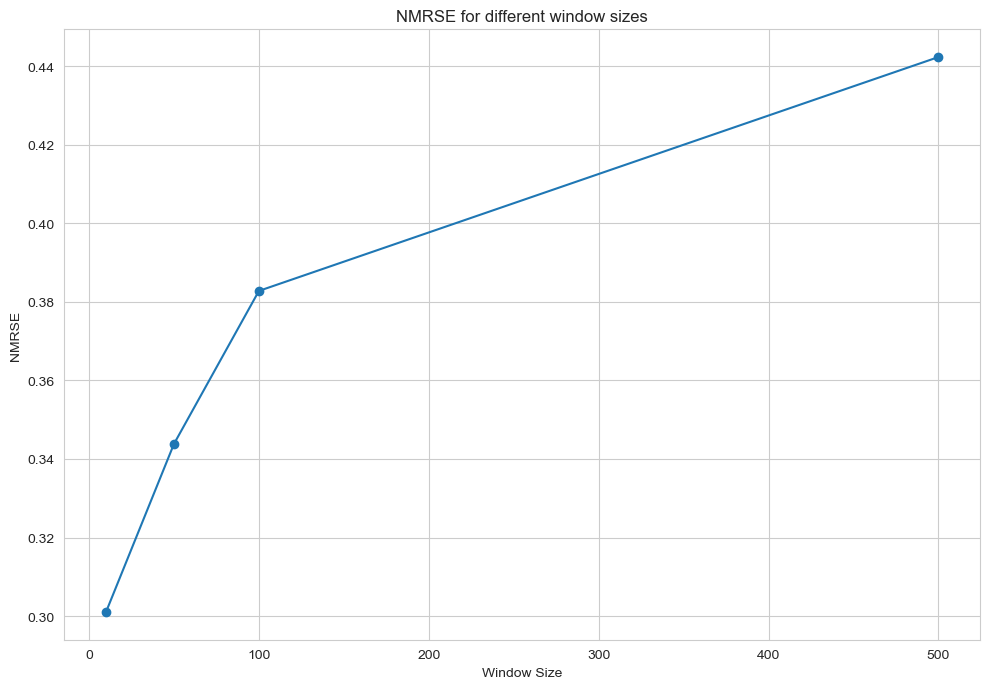

In [44]:
# Let's plot the NMRSE for the different window sizes
sizes = [score['window_size'] for score in window_scores]
nmrses = [score['nmrse'] for score in window_scores]

plt.figure(figsize=(10, 7))

plt.plot(sizes, nmrses, marker='o')

plt.xlabel('Window Size')
plt.ylabel('NMRSE')

plt.title('NMRSE for different window sizes')

plt.tight_layout()
plt.show()

In [45]:
# Get the best window size
best_window_size = window_scores[np.argmin(nmrses)]['window_size']

print(f'Best Window Size: {best_window_size}')

Best Window Size: 10


In [46]:
run_emas_optimisation = False

In [47]:
# Let's try applying the exponential moving average smoothing method to the data
# For these experiments, we will use the previously found best hyperparameters above

alphas = [0.001, 0.01, 0.1, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]

ema_scores = []

if run_emas_optimisation:
    for alpha in alphas:
        print(f'Alpha: {alpha}')
        X_train_ema, y_train_ema = data_preprocessor.exponential_moving_average(alpha, X_train_scaled, y_train_encoded)
        X_val_ema, y_val_ema = data_preprocessor.exponential_moving_average(alpha, X_val_scaled, y_val_encoded)
        X_test_ema, y_test_ema = data_preprocessor.exponential_moving_average(alpha, X_test_scaled, y_test_encoded)

        input_weights_1 = generate_input_weights(best_n_neurons_1, X_train_ema.shape[1], best_density_1,
                                                 best_weight_distribution_1,
                                                 seed=42)
        input_weights_2 = generate_input_weights(best_n_neurons_2, X_train_ema.shape[1], best_density_2,
                                                 best_weight_distribution_2,
                                                 seed=42)
        input_weights_3 = generate_input_weights(best_n_neurons_3, X_train_ema.shape[1], best_density_3,
                                                 best_weight_distribution_3,
                                                 seed=42)

        esn = ThreeHierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                                gamma_1=best_gamma_1,
                                W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1, sparsity_1=best_sparsity_1,
                                leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                                gamma_2=best_gamma_2,
                                W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2, sparsity_2=best_sparsity_2,
                                leakage_rate_3=best_leakage_rate_3, spectral_radius_3=best_spectral_radius_3,
                                gamma_3=best_gamma_3,
                                W_in_3=input_weights_3, n_neurons_3=best_n_neurons_3, sparsity_3=best_sparsity_3,
                                class_weights=class_weights, seed=42)

        # Fit the ESN
        esn.fit(X_train_ema, y_train_ema, x_val=X_val_ema, y_val=y_val_ema)

        # Predict the output
        y_pred = esn.forward(X_test_ema)

        # Decode the output
        y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_ema)
        y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred)

        # Calculate the nmrse
        nmrse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (
                y_pred_decoded.max() - y_pred_decoded.min())

        ema_scores.append({'alpha': alpha, 'nmrse': nmrse})

        print(f'Alpha: {alpha}, NMRSE: {nmrse}')

else:
    ema_scores = [{'alpha': 0.001, 'nmrse': 0.22202967819428818}, {'alpha': 0.01, 'nmrse': 0.22192377411936734},
                  {'alpha': 0.1, 'nmrse': 0.2208591480233581}, {'alpha': 0.5, 'nmrse': 0.21866566142224303},
                  {'alpha': 0.7, 'nmrse': 0.21913525446482193}, {'alpha': 0.8, 'nmrse': 0.2196940230206584},
                  {'alpha': 0.9, 'nmrse': 0.22047403507602367}, {'alpha': 0.95, 'nmrse': 0.2209680250391801},
                  {'alpha': 0.99, 'nmrse': 0.22137317394013545}, {'alpha': 0.999, 'nmrse': 0.22149113452529404}]

Alpha: 0.001
Smoothed data shape: (1357646, 6), (1357646, 7)
Smoothed data shape: (339404, 6), (339404, 7)
Smoothed data shape: (562547, 6), (562547, 7)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 0.6674647243532564, spectral_radius_3: 0.13303480091978592, gamma_3: 0.4754788170338825, n_neurons_3: 117
Step: 0/1357646
Step: 10000/1357646
Step: 20000/1357646
Step: 30000/1357646
Step: 40000/1357646
Step: 50000/1357646
Step: 60000/1357646
Step: 70000/1357646
Step: 80000/1357646
Step: 90000/1357646
Step: 100000/1357646
Step: 110000/1357646
Step: 120000/1357646
Step: 130000/1357646
Step: 140000/1357646
Step: 150000/1357646
Step: 160000/1357646
Step: 170000/1357646
Step: 180000/1357646
Step: 190000/1357646
Step: 200000/135

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.92138e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.23810804270615624
Alpha: 16.681005372000556, Score: 0.18041829450236677
Alpha: 129.15496650148827, Score: 0.12440481384566505
Alpha: 1000.0, Score: 0.09493743165250082
Best alpha: 0.03593813663804626
Readout layer fitted.
Step: 0/562547
Step: 10000/562547
Step: 20000/562547
Step: 30000/562547
Step: 40000/562547
Step: 50000/562547
Step: 60000/562547
Step: 70000/562547
Step: 80000/562547
Step: 90000/562547
Step: 100000/562547
Step: 110000/562547
Step: 120000/562547
Step: 130000/562547
Step: 140000/562547
Step: 150000/562547
Step: 160000/562547
Step: 170000/562547
Step: 180000/562547
Step: 190000/562547
Step: 200000/562547
Step: 210000/562547
Step: 220000/562547
Step: 230000/562547
Step: 240000/562547
Step: 250000/562547
Step: 260000/562547
Step: 270000/562547
Step: 280000/562547
Step: 290000/562547
Step: 300000/562547
Step: 310000/562547
Step: 320000/562547
Step: 330000/562547
Step: 340000/562547
Step: 350000/562547
Step: 360000/562547
Step: 370000/5625

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.93817e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.23806541837616582
Alpha: 16.681005372000556, Score: 0.1800588290242405
Alpha: 129.15496650148827, Score: 0.12418218160164682
Alpha: 1000.0, Score: 0.09486497615177056
Best alpha: 0.03593813663804626
Readout layer fitted.
Step: 0/562547
Step: 10000/562547
Step: 20000/562547
Step: 30000/562547
Step: 40000/562547
Step: 50000/562547
Step: 60000/562547
Step: 70000/562547
Step: 80000/562547
Step: 90000/562547
Step: 100000/562547
Step: 110000/562547
Step: 120000/562547
Step: 130000/562547
Step: 140000/562547
Step: 150000/562547
Step: 160000/562547
Step: 170000/562547
Step: 180000/562547
Step: 190000/562547
Step: 200000/562547
Step: 210000/562547
Step: 220000/562547
Step: 230000/562547
Step: 240000/562547
Step: 250000/562547
Step: 260000/562547
Step: 270000/562547
Step: 280000/562547
Step: 290000/562547
Step: 300000/562547
Step: 310000/562547
Step: 320000/562547
Step: 330000/562547
Step: 340000/562547
Step: 350000/562547
Step: 360000/562547
Step: 370000/56254

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.9179e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.23671602514325124
Alpha: 16.681005372000556, Score: 0.17677134452058446
Alpha: 129.15496650148827, Score: 0.12220700450089499
Alpha: 1000.0, Score: 0.09422909008243226
Best alpha: 0.03593813663804626
Readout layer fitted.
Step: 0/562547
Step: 10000/562547
Step: 20000/562547
Step: 30000/562547
Step: 40000/562547
Step: 50000/562547
Step: 60000/562547
Step: 70000/562547
Step: 80000/562547
Step: 90000/562547
Step: 100000/562547
Step: 110000/562547
Step: 120000/562547
Step: 130000/562547
Step: 140000/562547
Step: 150000/562547
Step: 160000/562547
Step: 170000/562547
Step: 180000/562547
Step: 190000/562547
Step: 200000/562547
Step: 210000/562547
Step: 220000/562547
Step: 230000/562547
Step: 240000/562547
Step: 250000/562547
Step: 260000/562547
Step: 270000/562547
Step: 280000/562547
Step: 290000/562547
Step: 300000/562547
Step: 310000/562547
Step: 320000/562547
Step: 330000/562547
Step: 340000/562547
Step: 350000/562547
Step: 360000/562547
Step: 370000/5625

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.94396e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.2329485012571257
Alpha: 16.681005372000556, Score: 0.1697802388438637
Alpha: 129.15496650148827, Score: 0.1184570848533101
Alpha: 1000.0, Score: 0.0930804662609366
Best alpha: 0.03593813663804626
Readout layer fitted.
Step: 0/562547
Step: 10000/562547
Step: 20000/562547
Step: 30000/562547
Step: 40000/562547
Step: 50000/562547
Step: 60000/562547
Step: 70000/562547
Step: 80000/562547
Step: 90000/562547
Step: 100000/562547
Step: 110000/562547
Step: 120000/562547
Step: 130000/562547
Step: 140000/562547
Step: 150000/562547
Step: 160000/562547
Step: 170000/562547
Step: 180000/562547
Step: 190000/562547
Step: 200000/562547
Step: 210000/562547
Step: 220000/562547
Step: 230000/562547
Step: 240000/562547
Step: 250000/562547
Step: 260000/562547
Step: 270000/562547
Step: 280000/562547
Step: 290000/562547
Step: 300000/562547
Step: 310000/562547
Step: 320000/562547
Step: 330000/562547
Step: 340000/562547
Step: 350000/562547
Step: 360000/562547
Step: 370000/562547
S

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.95098e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.23432248464002534
Alpha: 16.681005372000556, Score: 0.1716818845592417
Alpha: 129.15496650148827, Score: 0.11944751576763094
Alpha: 1000.0, Score: 0.09341408172696751
Best alpha: 0.03593813663804626
Readout layer fitted.
Step: 0/562547
Step: 10000/562547
Step: 20000/562547
Step: 30000/562547
Step: 40000/562547
Step: 50000/562547
Step: 60000/562547
Step: 70000/562547
Step: 80000/562547
Step: 90000/562547
Step: 100000/562547
Step: 110000/562547
Step: 120000/562547
Step: 130000/562547
Step: 140000/562547
Step: 150000/562547
Step: 160000/562547
Step: 170000/562547
Step: 180000/562547
Step: 190000/562547
Step: 200000/562547
Step: 210000/562547
Step: 220000/562547
Step: 230000/562547
Step: 240000/562547
Step: 250000/562547
Step: 260000/562547
Step: 270000/562547
Step: 280000/562547
Step: 290000/562547
Step: 300000/562547
Step: 310000/562547
Step: 320000/562547
Step: 330000/562547
Step: 340000/562547
Step: 350000/562547
Step: 360000/562547
Step: 370000/56254

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.92612e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.2356044833850112
Alpha: 16.681005372000556, Score: 0.17393693695852178
Alpha: 129.15496650148827, Score: 0.12066712219380038
Alpha: 1000.0, Score: 0.09381383854104522
Best alpha: 0.03593813663804626
Readout layer fitted.
Step: 0/562547
Step: 10000/562547
Step: 20000/562547
Step: 30000/562547
Step: 40000/562547
Step: 50000/562547
Step: 60000/562547
Step: 70000/562547
Step: 80000/562547
Step: 90000/562547
Step: 100000/562547
Step: 110000/562547
Step: 120000/562547
Step: 130000/562547
Step: 140000/562547
Step: 150000/562547
Step: 160000/562547
Step: 170000/562547
Step: 180000/562547
Step: 190000/562547
Step: 200000/562547
Step: 210000/562547
Step: 220000/562547
Step: 230000/562547
Step: 240000/562547
Step: 250000/562547
Step: 260000/562547
Step: 270000/562547
Step: 280000/562547
Step: 290000/562547
Step: 300000/562547
Step: 310000/562547
Step: 320000/562547
Step: 330000/562547
Step: 340000/562547
Step: 350000/562547
Step: 360000/562547
Step: 370000/56254

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.94459e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.23705193651357395
Alpha: 16.681005372000556, Score: 0.17698481071983155
Alpha: 129.15496650148827, Score: 0.12240187129830522
Alpha: 1000.0, Score: 0.09438309064342569
Best alpha: 0.03593813663804626
Readout layer fitted.
Step: 0/562547
Step: 10000/562547
Step: 20000/562547
Step: 30000/562547
Step: 40000/562547
Step: 50000/562547
Step: 60000/562547
Step: 70000/562547
Step: 80000/562547
Step: 90000/562547
Step: 100000/562547
Step: 110000/562547
Step: 120000/562547
Step: 130000/562547
Step: 140000/562547
Step: 150000/562547
Step: 160000/562547
Step: 170000/562547
Step: 180000/562547
Step: 190000/562547
Step: 200000/562547
Step: 210000/562547
Step: 220000/562547
Step: 230000/562547
Step: 240000/562547
Step: 250000/562547
Step: 260000/562547
Step: 270000/562547
Step: 280000/562547
Step: 290000/562547
Step: 300000/562547
Step: 310000/562547
Step: 320000/562547
Step: 330000/562547
Step: 340000/562547
Step: 350000/562547
Step: 360000/562547
Step: 370000/5625

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.91717e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.23823592863707585
Alpha: 16.681005372000556, Score: 0.18029155736545371
Alpha: 129.15496650148827, Score: 0.1244227643707363
Alpha: 1000.0, Score: 0.0950548199531978
Best alpha: 0.03593813663804626
Readout layer fitted.
Step: 0/562547
Step: 10000/562547
Step: 20000/562547
Step: 30000/562547
Step: 40000/562547
Step: 50000/562547
Step: 60000/562547
Step: 70000/562547
Step: 80000/562547
Step: 90000/562547
Step: 100000/562547
Step: 110000/562547
Step: 120000/562547
Step: 130000/562547
Step: 140000/562547
Step: 150000/562547
Step: 160000/562547
Step: 170000/562547
Step: 180000/562547
Step: 190000/562547
Step: 200000/562547
Step: 210000/562547
Step: 220000/562547
Step: 230000/562547
Step: 240000/562547
Step: 250000/562547
Step: 260000/562547
Step: 270000/562547
Step: 280000/562547
Step: 290000/562547
Step: 300000/562547
Step: 310000/562547
Step: 320000/562547
Step: 330000/562547
Step: 340000/562547
Step: 350000/562547
Step: 360000/562547
Step: 370000/562547

In [48]:
print(ema_scores)

[{'alpha': 0.001, 'nmrse': 0.22202967819428818}, {'alpha': 0.01, 'nmrse': 0.22192377411936734}, {'alpha': 0.1, 'nmrse': 0.2208591480233581}, {'alpha': 0.5, 'nmrse': 0.21866566142224303}, {'alpha': 0.7, 'nmrse': 0.21913525446482193}, {'alpha': 0.8, 'nmrse': 0.2196940230206584}, {'alpha': 0.9, 'nmrse': 0.22047403507602367}, {'alpha': 0.95, 'nmrse': 0.2209680250391801}, {'alpha': 0.99, 'nmrse': 0.22137317394013545}, {'alpha': 0.999, 'nmrse': 0.22149113452529404}]


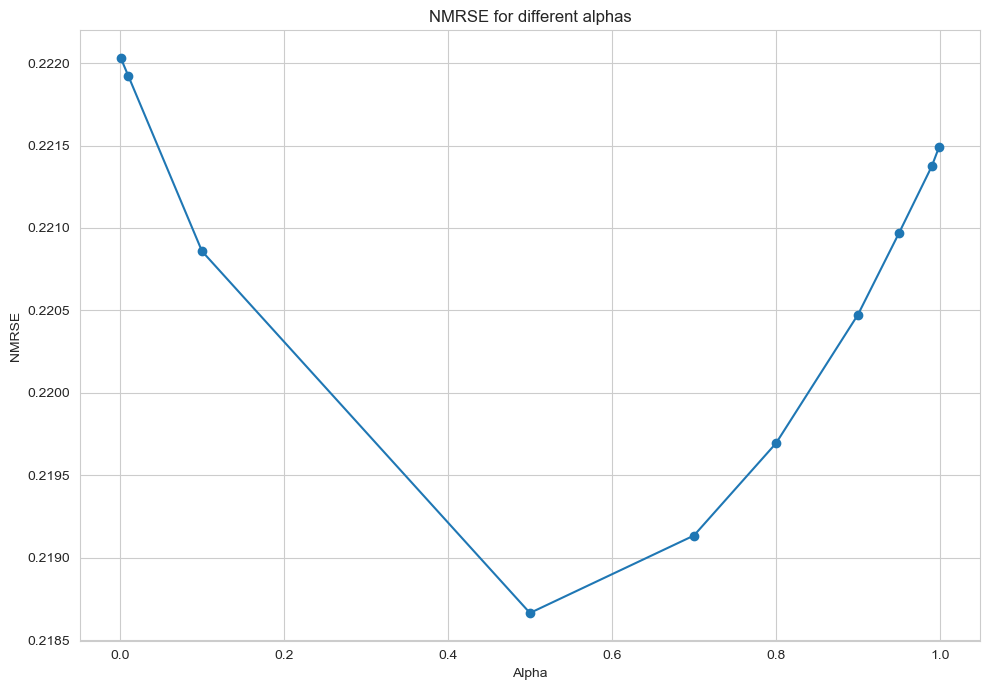

In [49]:
# Let's plot the NMRSE for the different alphas
alphas = [score['alpha'] for score in ema_scores]
nmrses = [score['nmrse'] for score in ema_scores]

plt.figure(figsize=(10, 7))

plt.plot(alphas, nmrses, marker='o')

plt.xlabel('Alpha')
plt.ylabel('NMRSE')

plt.title('NMRSE for different alphas')

plt.tight_layout()
plt.show()

In [50]:
# Get the best alpha
best_alpha = ema_scores[np.argmin(nmrses)]['alpha']

print(f'Best Alpha: {best_alpha}')

Best Alpha: 0.5


In [51]:
run_fourier_optimisation = False

In [52]:
# Let's try applying the fourier smoothing method to the data
# For these experiments, we will use the previously found best hyperparameters above

thresholds = [1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

fourier_scores = []

if run_fourier_optimisation:
    for threshold in thresholds:
        print(f'Threshold: {threshold}')
        X_train_fourier = data_preprocessor.fourier_smoothing(X_train_scaled, threshold)
        X_val_fourier = data_preprocessor.fourier_smoothing(X_val_scaled, threshold)
        X_test_fourier = data_preprocessor.fourier_smoothing(X_test_scaled, threshold)

        input_weights_1 = generate_input_weights(best_n_neurons_1, X_train_fourier.shape[1], best_density_1,
                                                 best_weight_distribution_1,
                                                 seed=42)
        input_weights_2 = generate_input_weights(best_n_neurons_2, X_train_fourier.shape[1], best_density_2,
                                                 best_weight_distribution_2,
                                                 seed=42)
        input_weights_3 = generate_input_weights(best_n_neurons_3, X_train_fourier.shape[1], best_density_3,
                                                 best_weight_distribution_3,
                                                 seed=42)

        esn = ThreeHierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                                gamma_1=best_gamma_1,
                                W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1, sparsity_1=best_sparsity_1,
                                leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                                gamma_2=best_gamma_2,
                                W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2, sparsity_2=best_sparsity_2,
                                leakage_rate_3=best_leakage_rate_3, spectral_radius_3=best_spectral_radius_3,
                                gamma_3=best_gamma_3,
                                W_in_3=input_weights_3, n_neurons_3=best_n_neurons_3, sparsity_3=best_sparsity_3,
                                class_weights=class_weights, seed=42)

        # Fit the ESN
        esn.fit(X_train_fourier, y_train_encoded, x_val=X_val_fourier, y_val=y_val_encoded)

        # Predict the output
        y_pred = esn.forward(X_test_fourier)

        # Decode the output
        y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_encoded)
        y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred)

        # Calculate the nmrse
        nmrse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (
                y_pred_decoded.max() - y_pred_decoded.min())

        fourier_scores.append({'threshold': threshold, 'nmrse': nmrse})

        print(f'Threshold: {threshold}, NMRSE: {nmrse}')

else:
    fourier_scores = [{'threshold': 1000.0, 'nmrse': 0.22132179228805673},
                      {'threshold': 100.0, 'nmrse': 0.22132179228805673},
                      {'threshold': 10.0, 'nmrse': 0.22132179228805673},
                      {'threshold': 1.0, 'nmrse': 0.22132179228805673}, {'threshold': 0.1, 'nmrse': 0.2202638918005431},
                      {'threshold': 0.01, 'nmrse': 0.30008353271263394},
                      {'threshold': 0.001, 'nmrse': 0.38053222137575826},
                      {'threshold': 0.0001, 'nmrse': 0.45700351103857517},
                      {'threshold': 1e-05, 'nmrse': 0.47193865859895556}]

Threshold: 1000.0
Fourier data shape: (1357646, 6)
Fourier data shape: (339404, 6)
Fourier data shape: (562547, 6)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 0.6674647243532564, spectral_radius_3: 0.13303480091978592, gamma_3: 0.4754788170338825, n_neurons_3: 117
Step: 0/1357646
Step: 10000/1357646
Step: 20000/1357646
Step: 30000/1357646
Step: 40000/1357646
Step: 50000/1357646
Step: 60000/1357646
Step: 70000/1357646
Step: 80000/1357646
Step: 90000/1357646
Step: 100000/1357646
Step: 110000/1357646
Step: 120000/1357646
Step: 130000/1357646
Step: 140000/1357646
Step: 150000/1357646
Step: 160000/1357646
Step: 170000/1357646
Step: 180000/1357646
Step: 190000/1357646
Step: 200000/1357646
Step: 210000/1357646
Step: 220000

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.97275e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.2382427144037125
Alpha: 16.681005372000556, Score: 0.18066571558900385
Alpha: 129.15496650148827, Score: 0.12467339671170616
Alpha: 1000.0, Score: 0.0951395616433033
Best alpha: 0.03593813663804626
Readout layer fitted.
Step: 0/562547
Step: 10000/562547
Step: 20000/562547
Step: 30000/562547
Step: 40000/562547
Step: 50000/562547
Step: 60000/562547
Step: 70000/562547
Step: 80000/562547
Step: 90000/562547
Step: 100000/562547
Step: 110000/562547
Step: 120000/562547
Step: 130000/562547
Step: 140000/562547
Step: 150000/562547
Step: 160000/562547
Step: 170000/562547
Step: 180000/562547
Step: 190000/562547
Step: 200000/562547
Step: 210000/562547
Step: 220000/562547
Step: 230000/562547
Step: 240000/562547
Step: 250000/562547
Step: 260000/562547
Step: 270000/562547
Step: 280000/562547
Step: 290000/562547
Step: 300000/562547
Step: 310000/562547
Step: 320000/562547
Step: 330000/562547
Step: 340000/562547
Step: 350000/562547
Step: 360000/562547
Step: 370000/562547

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.97275e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.2382427144037125
Alpha: 16.681005372000556, Score: 0.18066571558900385
Alpha: 129.15496650148827, Score: 0.12467339671170616
Alpha: 1000.0, Score: 0.0951395616433033
Best alpha: 0.03593813663804626
Readout layer fitted.
Step: 0/562547
Step: 10000/562547
Step: 20000/562547
Step: 30000/562547
Step: 40000/562547
Step: 50000/562547
Step: 60000/562547
Step: 70000/562547
Step: 80000/562547
Step: 90000/562547
Step: 100000/562547
Step: 110000/562547
Step: 120000/562547
Step: 130000/562547
Step: 140000/562547
Step: 150000/562547
Step: 160000/562547
Step: 170000/562547
Step: 180000/562547
Step: 190000/562547
Step: 200000/562547
Step: 210000/562547
Step: 220000/562547
Step: 230000/562547
Step: 240000/562547
Step: 250000/562547
Step: 260000/562547
Step: 270000/562547
Step: 280000/562547
Step: 290000/562547
Step: 300000/562547
Step: 310000/562547
Step: 320000/562547
Step: 330000/562547
Step: 340000/562547
Step: 350000/562547
Step: 360000/562547
Step: 370000/562547

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.97275e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.2382427144037125
Alpha: 16.681005372000556, Score: 0.18066571558900385
Alpha: 129.15496650148827, Score: 0.12467339671170616
Alpha: 1000.0, Score: 0.0951395616433033
Best alpha: 0.03593813663804626
Readout layer fitted.
Step: 0/562547
Step: 10000/562547
Step: 20000/562547
Step: 30000/562547
Step: 40000/562547
Step: 50000/562547
Step: 60000/562547
Step: 70000/562547
Step: 80000/562547
Step: 90000/562547
Step: 100000/562547
Step: 110000/562547
Step: 120000/562547
Step: 130000/562547
Step: 140000/562547
Step: 150000/562547
Step: 160000/562547
Step: 170000/562547
Step: 180000/562547
Step: 190000/562547
Step: 200000/562547
Step: 210000/562547
Step: 220000/562547
Step: 230000/562547
Step: 240000/562547
Step: 250000/562547
Step: 260000/562547
Step: 270000/562547
Step: 280000/562547
Step: 290000/562547
Step: 300000/562547
Step: 310000/562547
Step: 320000/562547
Step: 330000/562547
Step: 340000/562547
Step: 350000/562547
Step: 360000/562547
Step: 370000/562547

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.97275e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.2382427144037125
Alpha: 16.681005372000556, Score: 0.18066571558900385
Alpha: 129.15496650148827, Score: 0.12467339671170616
Alpha: 1000.0, Score: 0.0951395616433033
Best alpha: 0.03593813663804626
Readout layer fitted.
Step: 0/562547
Step: 10000/562547
Step: 20000/562547
Step: 30000/562547
Step: 40000/562547
Step: 50000/562547
Step: 60000/562547
Step: 70000/562547
Step: 80000/562547
Step: 90000/562547
Step: 100000/562547
Step: 110000/562547
Step: 120000/562547
Step: 130000/562547
Step: 140000/562547
Step: 150000/562547
Step: 160000/562547
Step: 170000/562547
Step: 180000/562547
Step: 190000/562547
Step: 200000/562547
Step: 210000/562547
Step: 220000/562547
Step: 230000/562547
Step: 240000/562547
Step: 250000/562547
Step: 260000/562547
Step: 270000/562547
Step: 280000/562547
Step: 290000/562547
Step: 300000/562547
Step: 310000/562547
Step: 320000/562547
Step: 330000/562547
Step: 340000/562547
Step: 350000/562547
Step: 360000/562547
Step: 370000/562547

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.91326e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.21175592465761012
Alpha: 16.681005372000556, Score: 0.1491060453188872
Alpha: 129.15496650148827, Score: 0.10979682275763092
Alpha: 1000.0, Score: 0.09049889863777946
Best alpha: 0.03593813663804626
Readout layer fitted.
Step: 0/562547
Step: 10000/562547
Step: 20000/562547
Step: 30000/562547
Step: 40000/562547
Step: 50000/562547
Step: 60000/562547
Step: 70000/562547
Step: 80000/562547
Step: 90000/562547
Step: 100000/562547
Step: 110000/562547
Step: 120000/562547
Step: 130000/562547
Step: 140000/562547
Step: 150000/562547
Step: 160000/562547
Step: 170000/562547
Step: 180000/562547
Step: 190000/562547
Step: 200000/562547
Step: 210000/562547
Step: 220000/562547
Step: 230000/562547
Step: 240000/562547
Step: 250000/562547
Step: 260000/562547
Step: 270000/562547
Step: 280000/562547
Step: 290000/562547
Step: 300000/562547
Step: 310000/562547
Step: 320000/562547
Step: 330000/562547
Step: 340000/562547
Step: 350000/562547
Step: 360000/562547
Step: 370000/56254

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.11409e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.1566988804371446
Alpha: 16.681005372000556, Score: 0.12455157742275544
Alpha: 129.15496650148827, Score: 0.10544522114942843
Alpha: 1000.0, Score: 0.09075085670239162
Best alpha: 0.004641588833612777
Readout layer fitted.
Step: 0/562547
Step: 10000/562547
Step: 20000/562547
Step: 30000/562547
Step: 40000/562547
Step: 50000/562547
Step: 60000/562547
Step: 70000/562547
Step: 80000/562547
Step: 90000/562547
Step: 100000/562547
Step: 110000/562547
Step: 120000/562547
Step: 130000/562547
Step: 140000/562547
Step: 150000/562547
Step: 160000/562547
Step: 170000/562547
Step: 180000/562547
Step: 190000/562547
Step: 200000/562547
Step: 210000/562547
Step: 220000/562547
Step: 230000/562547
Step: 240000/562547
Step: 250000/562547
Step: 260000/562547
Step: 270000/562547
Step: 280000/562547
Step: 290000/562547
Step: 300000/562547
Step: 310000/562547
Step: 320000/562547
Step: 330000/562547
Step: 340000/562547
Step: 350000/562547
Step: 360000/562547
Step: 370000/5625

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.45662e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.12549521665417113
Alpha: 16.681005372000556, Score: 0.10641125491300314
Alpha: 129.15496650148827, Score: 0.091426621149285
Alpha: 1000.0, Score: 0.08115003939923363
Best alpha: 0.03593813663804626
Readout layer fitted.
Step: 0/562547
Step: 10000/562547
Step: 20000/562547
Step: 30000/562547
Step: 40000/562547
Step: 50000/562547
Step: 60000/562547
Step: 70000/562547
Step: 80000/562547
Step: 90000/562547
Step: 100000/562547
Step: 110000/562547
Step: 120000/562547
Step: 130000/562547
Step: 140000/562547
Step: 150000/562547
Step: 160000/562547
Step: 170000/562547
Step: 180000/562547
Step: 190000/562547
Step: 200000/562547
Step: 210000/562547
Step: 220000/562547
Step: 230000/562547
Step: 240000/562547
Step: 250000/562547
Step: 260000/562547
Step: 270000/562547
Step: 280000/562547
Step: 290000/562547
Step: 300000/562547
Step: 310000/562547
Step: 320000/562547
Step: 330000/562547
Step: 340000/562547
Step: 350000/562547
Step: 360000/562547
Step: 370000/562547

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.63396e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.060573962134532845
Alpha: 16.681005372000556, Score: 0.05395063443737792
Alpha: 129.15496650148827, Score: 0.04699578981791708
Alpha: 1000.0, Score: 0.04223460029034497
Best alpha: 2.154434690031882


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.63396e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.
Step: 0/562547
Step: 10000/562547
Step: 20000/562547
Step: 30000/562547
Step: 40000/562547
Step: 50000/562547
Step: 60000/562547
Step: 70000/562547
Step: 80000/562547
Step: 90000/562547
Step: 100000/562547
Step: 110000/562547
Step: 120000/562547
Step: 130000/562547
Step: 140000/562547
Step: 150000/562547
Step: 160000/562547
Step: 170000/562547
Step: 180000/562547
Step: 190000/562547
Step: 200000/562547
Step: 210000/562547
Step: 220000/562547
Step: 230000/562547
Step: 240000/562547
Step: 250000/562547
Step: 260000/562547
Step: 270000/562547
Step: 280000/562547
Step: 290000/562547
Step: 300000/562547
Step: 310000/562547
Step: 320000/562547
Step: 330000/562547
Step: 340000/562547
Step: 350000/562547
Step: 360000/562547
Step: 370000/562547
Step: 380000/562547
Step: 390000/562547
Step: 400000/562547
Step: 410000/562547
Step: 420000/562547
Step: 430000/562547
Step: 440000/562547
Step: 450000/562547
Step: 460000/562547
Step: 470000/562547
Step: 480000/562547
Step: 490000

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.43364e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.2782559402207126, Score: -0.29587675474510117
Alpha: 2.154434690031882, Score: -0.10993260557187123
Alpha: 16.681005372000556, Score: -0.05546747877846471
Alpha: 129.15496650148827, Score: -0.13946004977866044
Alpha: 1000.0, Score: -0.14971541829088203
Best alpha: 16.681005372000556
Readout layer fitted.
Step: 0/562547
Step: 10000/562547
Step: 20000/562547
Step: 30000/562547
Step: 40000/562547
Step: 50000/562547
Step: 60000/562547
Step: 70000/562547
Step: 80000/562547
Step: 90000/562547
Step: 100000/562547
Step: 110000/562547
Step: 120000/562547
Step: 130000/562547
Step: 140000/562547
Step: 150000/562547
Step: 160000/562547
Step: 170000/562547
Step: 180000/562547
Step: 190000/562547
Step: 200000/562547
Step: 210000/562547
Step: 220000/562547
Step: 230000/562547
Step: 240000/562547
Step: 250000/562547
Step: 260000/562547
Step: 270000/562547
Step: 280000/562547
Step: 290000/562547
Step: 300000/562547
Step: 310000/562547
Step: 320000/562547
Step: 330000/562547
Step: 340000/562547

In [53]:
print(fourier_scores)

[{'threshold': 1000.0, 'nmrse': 0.22132179228805673}, {'threshold': 100.0, 'nmrse': 0.22132179228805673}, {'threshold': 10.0, 'nmrse': 0.22132179228805673}, {'threshold': 1.0, 'nmrse': 0.22132179228805673}, {'threshold': 0.1, 'nmrse': 0.2202638918005431}, {'threshold': 0.01, 'nmrse': 0.30008353271263394}, {'threshold': 0.001, 'nmrse': 0.38053222137575826}, {'threshold': 0.0001, 'nmrse': 0.45700351103857517}, {'threshold': 1e-05, 'nmrse': 0.47193865859895556}]


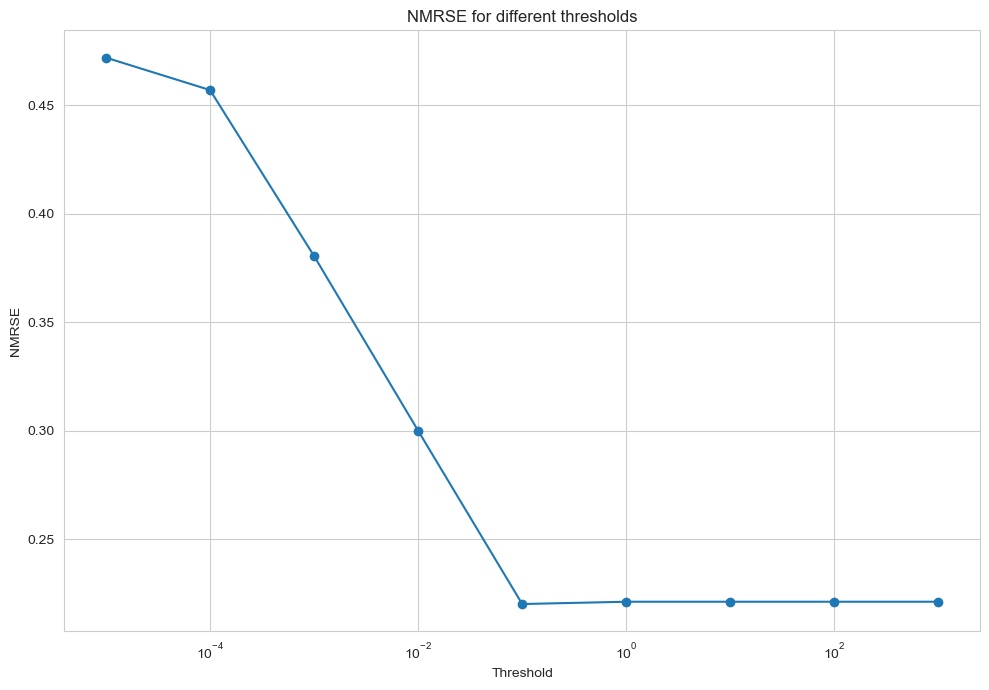

In [54]:
# Let's plot the NMRSE for the different thresholds
thresholds = [score['threshold'] for score in fourier_scores]
nmrses = [score['nmrse'] for score in fourier_scores]

plt.figure(figsize=(10, 7))

plt.plot(thresholds, nmrses, marker='o')

plt.xlabel('Threshold')
plt.ylabel('NMRSE')
plt.xscale('log')

plt.title('NMRSE for different thresholds')

plt.tight_layout()
plt.show()

In [55]:
# Get the best threshold
best_threshold = fourier_scores[np.argmin(nmrses)]['threshold']

print(f'Best Threshold: {best_threshold}')

Best Threshold: 0.1


In [56]:
run_fourier_window_optimisation = False

In [58]:
# As with the previous baselines, we will apply the fourier smoothing method followed by the buffered windows method

window_sizes = [10, 50, 100, 500]
thresholds = [1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

pipeline_steps = ['fourier_smoothing', 'buffered_windows']

fourier_window_scores = []

if run_fourier_window_optimisation:
    for threshold in thresholds:
        for window_size in window_sizes:
            print(f'Threshold: {threshold}, Window Size: {window_size}')

            pipeline_params = [threshold, window_size]

            x_train_windowed_fourier, y_train_windowed_fourier = data_preprocessor.pipeline(pipeline_steps,
                                                                                            X_train_scaled,
                                                                                            y_train_encoded,
                                                                                            pipeline_params)

            x_val_windowed_fourier, y_val_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_val_scaled,
                                                                                        y_val_encoded, pipeline_params)

            x_test_windowed_fourier, y_test_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_test_scaled,
                                                                                          y_test_encoded,
                                                                                          pipeline_params)

            input_weights_1 = generate_input_weights(best_n_neurons_1, x_train_windowed_fourier.shape[1],
                                                     best_density_1, best_weight_distribution_1,
                                                     seed=42)

            input_weights_2 = generate_input_weights(best_n_neurons_2, x_train_windowed_fourier.shape[1],
                                                     best_density_2, best_weight_distribution_2,
                                                     seed=42)

            input_weights_3 = generate_input_weights(best_n_neurons_3, x_train_windowed_fourier.shape[1],
                                                     best_density_3, best_weight_distribution_3,
                                                     seed=42)

            esn = ThreeHierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                                    gamma_1=best_gamma_1,
                                    W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1, sparsity_1=best_sparsity_1,
                                    leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                                    gamma_2=best_gamma_2,
                                    W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2, sparsity_2=best_sparsity_2,
                                    leakage_rate_3=best_leakage_rate_3, spectral_radius_3=best_spectral_radius_3,
                                    gamma_3=best_gamma_3,
                                    W_in_3=input_weights_3, n_neurons_3=best_n_neurons_3, sparsity_3=best_sparsity_3,
                                    class_weights=class_weights, seed=42)

            # Fit the ESN
            esn.fit(x_train_windowed_fourier, y_train_windowed_fourier, x_val=x_val_windowed_fourier,
                    y_val=y_val_windowed_fourier)

            # Predict the output
            y_pred = esn.forward(x_test_windowed_fourier)

            # Decode the output
            # We need to decode the output as it is one-hot encoded
            # But the windowed data is in the shape of (n_samples//window_size, n_classes * window_size), we need to reshape it to (n_samples, n_classes)
            y_test_resized = y_test_windowed_fourier.reshape(-1, y_test_windowed_fourier.shape[-1] // window_size)
            y_pred_resized = y_pred.reshape(-1, y_pred.shape[-1] // window_size)

            y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_resized)
            y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred_resized)

            # Calculate the nmrse
            nmrse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (
                    y_pred_decoded.max() - y_pred_decoded.min())

            fourier_window_scores.append({'threshold': threshold, 'window_size': window_size, 'nmrse': nmrse})

            print(f'Threshold: {threshold}, Window Size: {window_size}, NMRSE: {nmrse}')

else:
    fourier_window_scores = [{'threshold': 1000.0, 'window_size': 10, 'nmrse': 0.29905507341964926},
                             {'threshold': 1000.0, 'window_size': 50, 'nmrse': 0.34275528492772084},
                             {'threshold': 1000.0, 'window_size': 100, 'nmrse': 0.380062351146032},
                             {'threshold': 1000.0, 'window_size': 500, 'nmrse': 0.4426749426703922},
                             {'threshold': 100.0, 'window_size': 10, 'nmrse': 0.29905507341964926},
                             {'threshold': 100.0, 'window_size': 50, 'nmrse': 0.34275528492772084},
                             {'threshold': 100.0, 'window_size': 100, 'nmrse': 0.380062351146032},
                             {'threshold': 100.0, 'window_size': 500, 'nmrse': 0.4426749426703922},
                             {'threshold': 10.0, 'window_size': 10, 'nmrse': 0.29905507341964926},
                             {'threshold': 10.0, 'window_size': 50, 'nmrse': 0.34275528492772084},
                             {'threshold': 10.0, 'window_size': 100, 'nmrse': 0.380062351146032},
                             {'threshold': 10.0, 'window_size': 500, 'nmrse': 0.4426749426703922},
                             {'threshold': 1.0, 'window_size': 10, 'nmrse': 0.29905507341964926},
                             {'threshold': 1.0, 'window_size': 50, 'nmrse': 0.34275528492772084},
                             {'threshold': 1.0, 'window_size': 100, 'nmrse': 0.380062351146032},
                             {'threshold': 1.0, 'window_size': 500, 'nmrse': 0.4426749426703922},
                             {'threshold': 0.1, 'window_size': 10, 'nmrse': 0.2545119234976339},
                             {'threshold': 0.1, 'window_size': 50, 'nmrse': 0.3605748227749129},
                             {'threshold': 0.1, 'window_size': 100, 'nmrse': 0.3917390055623776},
                             {'threshold': 0.1, 'window_size': 500, 'nmrse': 0.4585903877395577},
                             {'threshold': 0.01, 'window_size': 10, 'nmrse': 0.3254585176820693},
                             {'threshold': 0.01, 'window_size': 50, 'nmrse': 0.4047477258797035},
                             {'threshold': 0.01, 'window_size': 100, 'nmrse': 0.40631339874726324},
                             {'threshold': 0.01, 'window_size': 500, 'nmrse': 0.46127175457163266},
                             {'threshold': 0.001, 'window_size': 10, 'nmrse': 0.3557349243213137},
                             {'threshold': 0.001, 'window_size': 50, 'nmrse': 0.39545072265135855},
                             {'threshold': 0.001, 'window_size': 100, 'nmrse': 0.4213804739249544},
                             {'threshold': 0.001, 'window_size': 500, 'nmrse': 0.4643817947546234},
                             {'threshold': 0.0001, 'window_size': 10, 'nmrse': 0.4333324101049198},
                             {'threshold': 0.0001, 'window_size': 50, 'nmrse': 0.41311373915455063},
                             {'threshold': 0.0001, 'window_size': 100, 'nmrse': 0.4384393711526989},
                             {'threshold': 0.0001, 'window_size': 500, 'nmrse': 0.4653077385455436},
                             {'threshold': 1e-05, 'window_size': 10, 'nmrse': 0.5442023007533244},
                             {'threshold': 1e-05, 'window_size': 50, 'nmrse': 0.48319518475746787},
                             {'threshold': 1e-05, 'window_size': 100, 'nmrse': 0.5108821418516197},
                             {'threshold': 1e-05, 'window_size': 500, 'nmrse': 0.5443885023800411}]

Threshold: 1000.0, Window Size: 10
Fourier data shape: (1357646, 6)
Buffered data shape: (135765, 60), (135765, 70)
Fourier data shape: (339404, 6)
Buffered data shape: (33941, 60), (33941, 70)
Fourier data shape: (562547, 6)
Buffered data shape: (56255, 60), (56255, 70)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 0.6674647243532564, spectral_radius_3: 0.13303480091978592, gamma_3: 0.4754788170338825, n_neurons_3: 117
Step: 0/135765
Step: 10000/135765
Step: 20000/135765
Step: 30000/135765
Step: 40000/135765
Step: 50000/135765
Step: 60000/135765
Step: 70000/135765
Step: 80000/135765
Step: 90000/135765
Step: 100000/135765
Step: 110000/135765
Step: 120000/135765
Step: 5765/135765
Shape of previous_states: (135765, 500)

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.52519e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.0005994842503189409, Score: 0.07296276230966033


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.2548e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: 0.13782243340682584


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.21027e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.03593813663804626, Score: 0.1712835930328869
Alpha: 0.2782559402207126, Score: 0.2045671029673553
Alpha: 2.154434690031882, Score: 0.2183227764276809
Alpha: 16.681005372000556, Score: 0.20453787552689043
Alpha: 129.15496650148827, Score: 0.15093190496704867
Alpha: 1000.0, Score: 0.08992717425224461
Best alpha: 2.154434690031882
Readout layer fitted.
Step: 0/56255
Step: 10000/56255
Step: 20000/56255
Step: 30000/56255
Step: 40000/56255
Step: 6255/56255
Shape of previous_states: (56255, 500)
Threshold: 1000.0, Window Size: 10, NMRSE: 0.29905507341964926
Threshold: 1000.0, Window Size: 50
Fourier data shape: (1357646, 6)
Buffered data shape: (27153, 300), (27153, 350)
Fourier data shape: (339404, 6)
Buffered data shape: (6789, 300), (6789, 350)
Fourier data shape: (562547, 6)
Buffered data shape: (11251, 300), (11251, 350)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769,

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.62007e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.93712e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -0.07012305950192019
Alpha: 0.03593813663804626, Score: 0.030270910196232258


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.69803e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.2782559402207126, Score: 0.09551913810307673
Alpha: 2.154434690031882, Score: 0.13812182577845025
Alpha: 16.681005372000556, Score: 0.16016316621431925
Alpha: 129.15496650148827, Score: 0.12877732078384102
Alpha: 1000.0, Score: 0.06363786198909659
Best alpha: 16.681005372000556
Readout layer fitted.
Step: 0/11251
Step: 1251/11251
Shape of previous_states: (11251, 500)
Threshold: 1000.0, Window Size: 50, NMRSE: 0.34275528492772084
Threshold: 1000.0, Window Size: 100
Fourier data shape: (1357646, 6)
Buffered data shape: (13577, 600), (13577, 700)
Fourier data shape: (339404, 6)
Buffered data shape: (3395, 600), (3395, 700)
Fourier data shape: (562547, 6)
Buffered data shape: (5626, 600), (5626, 700)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.48591e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.55706e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -0.08951624292398314
Alpha: 0.03593813663804626, Score: -0.013037658814753349
Alpha: 0.2782559402207126, Score: 0.06569297784066949
Alpha: 2.154434690031882, Score: 0.11857790554429073
Alpha: 16.681005372000556, Score: 0.12535850741200252
Alpha: 129.15496650148827, Score: 0.10301331902137503
Alpha: 1000.0, Score: 0.0561271000840023
Best alpha: 16.681005372000556
Readout layer fitted.
Step: 5626/5626
Shape of previous_states: (5626, 500)
Threshold: 1000.0, Window Size: 100, NMRSE: 0.380062351146032
Threshold: 1000.0, Window Size: 500
Fourier data shape: (1357646, 6)
Buffered data shape: (2716, 3000), (2716, 3500)
Fourier data shape: (339404, 6)
Buffered data shape: (679, 3000), (679, 3500)
Fourier data shape: (562547, 6)
Buffered data shape: (1126, 3000), (1126, 3500)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.87621e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -0.797119026176453
Alpha: 0.03593813663804626, Score: -0.6186971088649333
Alpha: 0.2782559402207126, Score: -0.3423544038919168
Alpha: 2.154434690031882, Score: -0.1026708882958001
Alpha: 16.681005372000556, Score: -0.005824918980041585
Alpha: 129.15496650148827, Score: 0.011526418264503662
Alpha: 1000.0, Score: -0.033973123430756196
Best alpha: 129.15496650148827
Readout layer fitted.
Step: 1126/1126
Shape of previous_states: (1126, 500)
Threshold: 1000.0, Window Size: 500, NMRSE: 0.4426749426703922
Threshold: 100.0, Window Size: 10
Fourier data shape: (1357646, 6)
Buffered data shape: (135765, 60), (135765, 70)
Fourier data shape: (339404, 6)
Buffered data shape: (33941, 60), (33941, 70)
Fourier data shape: (562547, 6)
Buffered data shape: (56255, 60), (56255, 70)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.52519e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.0005994842503189409, Score: 0.07296276230966033


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.2548e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: 0.13782243340682584


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.21027e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.03593813663804626, Score: 0.1712835930328869
Alpha: 0.2782559402207126, Score: 0.2045671029673553
Alpha: 2.154434690031882, Score: 0.2183227764276809
Alpha: 16.681005372000556, Score: 0.20453787552689043
Alpha: 129.15496650148827, Score: 0.15093190496704867
Alpha: 1000.0, Score: 0.08992717425224461
Best alpha: 2.154434690031882
Readout layer fitted.
Step: 0/56255
Step: 10000/56255
Step: 20000/56255
Step: 30000/56255
Step: 40000/56255
Step: 6255/56255
Shape of previous_states: (56255, 500)
Threshold: 100.0, Window Size: 10, NMRSE: 0.29905507341964926
Threshold: 100.0, Window Size: 50
Fourier data shape: (1357646, 6)
Buffered data shape: (27153, 300), (27153, 350)
Fourier data shape: (339404, 6)
Buffered data shape: (6789, 300), (6789, 350)
Fourier data shape: (562547, 6)
Buffered data shape: (11251, 300), (11251, 350)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.62007e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.0005994842503189409, Score: -0.13297357604576124


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.93712e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -0.07012305950192019


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.69803e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.03593813663804626, Score: 0.030270910196232258
Alpha: 0.2782559402207126, Score: 0.09551913810307673
Alpha: 2.154434690031882, Score: 0.13812182577845025
Alpha: 16.681005372000556, Score: 0.16016316621431925
Alpha: 129.15496650148827, Score: 0.12877732078384102
Alpha: 1000.0, Score: 0.06363786198909659
Best alpha: 16.681005372000556
Readout layer fitted.
Step: 0/11251
Step: 1251/11251
Shape of previous_states: (11251, 500)
Threshold: 100.0, Window Size: 50, NMRSE: 0.34275528492772084
Threshold: 100.0, Window Size: 100
Fourier data shape: (1357646, 6)
Buffered data shape: (13577, 600), (13577, 700)
Fourier data shape: (339404, 6)
Buffered data shape: (3395, 600), (3395, 700)
Fourier data shape: (562547, 6)
Buffered data shape: (5626, 600), (5626, 700)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.48591e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.55706e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -0.08951624292398314
Alpha: 0.03593813663804626, Score: -0.013037658814753349
Alpha: 0.2782559402207126, Score: 0.06569297784066949
Alpha: 2.154434690031882, Score: 0.11857790554429073
Alpha: 16.681005372000556, Score: 0.12535850741200252
Alpha: 129.15496650148827, Score: 0.10301331902137503
Alpha: 1000.0, Score: 0.0561271000840023
Best alpha: 16.681005372000556
Readout layer fitted.
Step: 5626/5626
Shape of previous_states: (5626, 500)
Threshold: 100.0, Window Size: 100, NMRSE: 0.380062351146032
Threshold: 100.0, Window Size: 500
Fourier data shape: (1357646, 6)
Buffered data shape: (2716, 3000), (2716, 3500)
Fourier data shape: (339404, 6)
Buffered data shape: (679, 3000), (679, 3500)
Fourier data shape: (562547, 6)
Buffered data shape: (1126, 3000), (1126, 3500)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_r

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.87621e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -0.797119026176453
Alpha: 0.03593813663804626, Score: -0.6186971088649333
Alpha: 0.2782559402207126, Score: -0.3423544038919168
Alpha: 2.154434690031882, Score: -0.1026708882958001
Alpha: 16.681005372000556, Score: -0.005824918980041585
Alpha: 129.15496650148827, Score: 0.011526418264503662
Alpha: 1000.0, Score: -0.033973123430756196
Best alpha: 129.15496650148827
Readout layer fitted.
Step: 1126/1126
Shape of previous_states: (1126, 500)
Threshold: 100.0, Window Size: 500, NMRSE: 0.4426749426703922
Threshold: 10.0, Window Size: 10
Fourier data shape: (1357646, 6)
Buffered data shape: (135765, 60), (135765, 70)
Fourier data shape: (339404, 6)
Buffered data shape: (33941, 60), (33941, 70)
Fourier data shape: (562547, 6)
Buffered data shape: (56255, 60), (56255, 70)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_ra

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.52519e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.0005994842503189409, Score: 0.07296276230966033


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.2548e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: 0.13782243340682584


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.21027e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.03593813663804626, Score: 0.1712835930328869
Alpha: 0.2782559402207126, Score: 0.2045671029673553
Alpha: 2.154434690031882, Score: 0.2183227764276809
Alpha: 16.681005372000556, Score: 0.20453787552689043
Alpha: 129.15496650148827, Score: 0.15093190496704867
Alpha: 1000.0, Score: 0.08992717425224461
Best alpha: 2.154434690031882
Readout layer fitted.
Step: 0/56255
Step: 10000/56255
Step: 20000/56255
Step: 30000/56255
Step: 40000/56255
Step: 6255/56255
Shape of previous_states: (56255, 500)
Threshold: 10.0, Window Size: 10, NMRSE: 0.29905507341964926
Threshold: 10.0, Window Size: 50
Fourier data shape: (1357646, 6)
Buffered data shape: (27153, 300), (27153, 350)
Fourier data shape: (339404, 6)
Buffered data shape: (6789, 300), (6789, 350)
Fourier data shape: (562547, 6)
Buffered data shape: (11251, 300), (11251, 350)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_n

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.62007e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.93712e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.0005994842503189409, Score: -0.13297357604576124
Alpha: 0.004641588833612777, Score: -0.07012305950192019


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.69803e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.03593813663804626, Score: 0.030270910196232258
Alpha: 0.2782559402207126, Score: 0.09551913810307673
Alpha: 2.154434690031882, Score: 0.13812182577845025
Alpha: 16.681005372000556, Score: 0.16016316621431925
Alpha: 129.15496650148827, Score: 0.12877732078384102
Alpha: 1000.0, Score: 0.06363786198909659
Best alpha: 16.681005372000556
Readout layer fitted.
Step: 0/11251
Step: 1251/11251
Shape of previous_states: (11251, 500)
Threshold: 10.0, Window Size: 50, NMRSE: 0.34275528492772084
Threshold: 10.0, Window Size: 100
Fourier data shape: (1357646, 6)
Buffered data shape: (13577, 600), (13577, 700)
Fourier data shape: (339404, 6)
Buffered data shape: (3395, 600), (3395, 700)
Fourier data shape: (562547, 6)
Buffered data shape: (5626, 600), (5626, 700)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.48591e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.55706e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -0.08951624292398314
Alpha: 0.03593813663804626, Score: -0.013037658814753349
Alpha: 0.2782559402207126, Score: 0.06569297784066949
Alpha: 2.154434690031882, Score: 0.11857790554429073
Alpha: 16.681005372000556, Score: 0.12535850741200252
Alpha: 129.15496650148827, Score: 0.10301331902137503
Alpha: 1000.0, Score: 0.0561271000840023
Best alpha: 16.681005372000556
Readout layer fitted.
Step: 5626/5626
Shape of previous_states: (5626, 500)
Threshold: 10.0, Window Size: 100, NMRSE: 0.380062351146032
Threshold: 10.0, Window Size: 500
Fourier data shape: (1357646, 6)
Buffered data shape: (2716, 3000), (2716, 3500)
Fourier data shape: (339404, 6)
Buffered data shape: (679, 3000), (679, 3500)
Fourier data shape: (562547, 6)
Buffered data shape: (1126, 3000), (1126, 3500)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rat

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.87621e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -0.797119026176453
Alpha: 0.03593813663804626, Score: -0.6186971088649333
Alpha: 0.2782559402207126, Score: -0.3423544038919168
Alpha: 2.154434690031882, Score: -0.1026708882958001
Alpha: 16.681005372000556, Score: -0.005824918980041585
Alpha: 129.15496650148827, Score: 0.011526418264503662
Alpha: 1000.0, Score: -0.033973123430756196
Best alpha: 129.15496650148827
Readout layer fitted.
Step: 1126/1126
Shape of previous_states: (1126, 500)
Threshold: 10.0, Window Size: 500, NMRSE: 0.4426749426703922
Threshold: 1.0, Window Size: 10
Fourier data shape: (1357646, 6)
Buffered data shape: (135765, 60), (135765, 70)
Fourier data shape: (339404, 6)
Buffered data shape: (33941, 60), (33941, 70)
Fourier data shape: (562547, 6)
Buffered data shape: (56255, 60), (56255, 70)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.52519e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.0005994842503189409, Score: 0.07296276230966033


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.2548e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: 0.13782243340682584


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.21027e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.03593813663804626, Score: 0.1712835930328869
Alpha: 0.2782559402207126, Score: 0.2045671029673553
Alpha: 2.154434690031882, Score: 0.2183227764276809
Alpha: 16.681005372000556, Score: 0.20453787552689043
Alpha: 129.15496650148827, Score: 0.15093190496704867
Alpha: 1000.0, Score: 0.08992717425224461
Best alpha: 2.154434690031882
Readout layer fitted.
Step: 0/56255
Step: 10000/56255
Step: 20000/56255
Step: 30000/56255
Step: 40000/56255
Step: 6255/56255
Shape of previous_states: (56255, 500)
Threshold: 1.0, Window Size: 10, NMRSE: 0.29905507341964926
Threshold: 1.0, Window Size: 50
Fourier data shape: (1357646, 6)
Buffered data shape: (27153, 300), (27153, 350)
Fourier data shape: (339404, 6)
Buffered data shape: (6789, 300), (6789, 350)
Fourier data shape: (562547, 6)
Buffered data shape: (11251, 300), (11251, 350)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neu

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.62007e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.93712e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.0005994842503189409, Score: -0.13297357604576124
Alpha: 0.004641588833612777, Score: -0.07012305950192019


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.69803e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.03593813663804626, Score: 0.030270910196232258
Alpha: 0.2782559402207126, Score: 0.09551913810307673
Alpha: 2.154434690031882, Score: 0.13812182577845025
Alpha: 16.681005372000556, Score: 0.16016316621431925
Alpha: 129.15496650148827, Score: 0.12877732078384102
Alpha: 1000.0, Score: 0.06363786198909659
Best alpha: 16.681005372000556
Readout layer fitted.
Step: 0/11251
Step: 1251/11251
Shape of previous_states: (11251, 500)
Threshold: 1.0, Window Size: 50, NMRSE: 0.34275528492772084
Threshold: 1.0, Window Size: 100
Fourier data shape: (1357646, 6)
Buffered data shape: (13577, 600), (13577, 700)
Fourier data shape: (339404, 6)
Buffered data shape: (3395, 600), (3395, 700)
Fourier data shape: (562547, 6)
Buffered data shape: (5626, 600), (5626, 700)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.48591e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.55706e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -0.08951624292398314
Alpha: 0.03593813663804626, Score: -0.013037658814753349
Alpha: 0.2782559402207126, Score: 0.06569297784066949
Alpha: 2.154434690031882, Score: 0.11857790554429073
Alpha: 16.681005372000556, Score: 0.12535850741200252
Alpha: 129.15496650148827, Score: 0.10301331902137503
Alpha: 1000.0, Score: 0.0561271000840023
Best alpha: 16.681005372000556
Readout layer fitted.
Step: 5626/5626
Shape of previous_states: (5626, 500)
Threshold: 1.0, Window Size: 100, NMRSE: 0.380062351146032
Threshold: 1.0, Window Size: 500
Fourier data shape: (1357646, 6)
Buffered data shape: (2716, 3000), (2716, 3500)
Fourier data shape: (339404, 6)
Buffered data shape: (679, 3000), (679, 3500)
Fourier data shape: (562547, 6)
Buffered data shape: (1126, 3000), (1126, 3500)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.87621e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -0.797119026176453
Alpha: 0.03593813663804626, Score: -0.6186971088649333
Alpha: 0.2782559402207126, Score: -0.3423544038919168
Alpha: 2.154434690031882, Score: -0.1026708882958001
Alpha: 16.681005372000556, Score: -0.005824918980041585
Alpha: 129.15496650148827, Score: 0.011526418264503662
Alpha: 1000.0, Score: -0.033973123430756196
Best alpha: 129.15496650148827
Readout layer fitted.
Step: 1126/1126
Shape of previous_states: (1126, 500)
Threshold: 1.0, Window Size: 500, NMRSE: 0.4426749426703922
Threshold: 0.1, Window Size: 10
Fourier data shape: (1357646, 6)
Buffered data shape: (135765, 60), (135765, 70)
Fourier data shape: (339404, 6)
Buffered data shape: (33941, 60), (33941, 70)
Fourier data shape: (562547, 6)
Buffered data shape: (56255, 60), (56255, 70)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.17356e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.03593813663804626, Score: 0.22183538920078777
Alpha: 0.2782559402207126, Score: 0.21683303042065707
Alpha: 2.154434690031882, Score: 0.21519337196788765
Alpha: 16.681005372000556, Score: 0.17839534673186389
Alpha: 129.15496650148827, Score: 0.119747226525772
Alpha: 1000.0, Score: 0.07851425991822117
Best alpha: 0.004641588833612777
Readout layer fitted.
Step: 0/56255
Step: 10000/56255
Step: 20000/56255
Step: 30000/56255
Step: 40000/56255
Step: 6255/56255
Shape of previous_states: (56255, 500)
Threshold: 0.1, Window Size: 10, NMRSE: 0.2545119234976339
Threshold: 0.1, Window Size: 50
Fourier data shape: (1357646, 6)
Buffered data shape: (27153, 300), (27153, 350)
Fourier data shape: (339404, 6)
Buffered data shape: (6789, 300), (6789, 350)
Fourier data shape: (562547, 6)
Buffered data shape: (11251, 300), (11251, 350)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.43116e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.88325e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.0005994842503189409, Score: -0.2517242886855699
Alpha: 0.004641588833612777, Score: -0.2020205955120089


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.67155e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.03593813663804626, Score: -0.016816237469911226
Alpha: 0.2782559402207126, Score: 0.0988465150765579
Alpha: 2.154434690031882, Score: 0.14642536768994693
Alpha: 16.681005372000556, Score: 0.15456383766324452
Alpha: 129.15496650148827, Score: 0.10505865358578194
Alpha: 1000.0, Score: 0.050595667480039005
Best alpha: 16.681005372000556
Readout layer fitted.
Step: 0/11251
Step: 1251/11251
Shape of previous_states: (11251, 500)
Threshold: 0.1, Window Size: 50, NMRSE: 0.3605748227749129
Threshold: 0.1, Window Size: 100
Fourier data shape: (1357646, 6)
Buffered data shape: (13577, 600), (13577, 700)
Fourier data shape: (339404, 6)
Buffered data shape: (3395, 600), (3395, 700)
Fourier data shape: (562547, 6)
Buffered data shape: (5626, 600), (5626, 700)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.47301e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.3865e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -0.023151902515396807
Alpha: 0.03593813663804626, Score: 0.04873958987610314
Alpha: 0.2782559402207126, Score: 0.10548715801300602
Alpha: 2.154434690031882, Score: 0.12649560505013846
Alpha: 16.681005372000556, Score: 0.12603982273817574
Alpha: 129.15496650148827, Score: 0.0922126041094422
Alpha: 1000.0, Score: 0.04767460876076306
Best alpha: 2.154434690031882
Readout layer fitted.
Step: 5626/5626
Shape of previous_states: (5626, 500)
Threshold: 0.1, Window Size: 100, NMRSE: 0.3917390055623776
Threshold: 0.1, Window Size: 500
Fourier data shape: (1357646, 6)
Buffered data shape: (2716, 3000), (2716, 3500)
Fourier data shape: (339404, 6)
Buffered data shape: (679, 3000), (679, 3500)
Fourier data shape: (562547, 6)
Buffered data shape: (1126, 3000), (1126, 3500)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.45219e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -0.40472610983981383
Alpha: 0.03593813663804626, Score: -0.3281744165649308
Alpha: 0.2782559402207126, Score: -0.12987715952510515
Alpha: 2.154434690031882, Score: -0.019271274441995386
Alpha: 16.681005372000556, Score: 0.0263464464496766
Alpha: 129.15496650148827, Score: 0.01978949808426036
Alpha: 1000.0, Score: -0.028859151380355302
Best alpha: 16.681005372000556
Readout layer fitted.
Step: 1126/1126
Shape of previous_states: (1126, 500)
Threshold: 0.1, Window Size: 500, NMRSE: 0.4585903877395577
Threshold: 0.01, Window Size: 10
Fourier data shape: (1357646, 6)
Buffered data shape: (135765, 60), (135765, 70)
Fourier data shape: (339404, 6)
Buffered data shape: (33941, 60), (33941, 70)
Fourier data shape: (562547, 6)
Buffered data shape: (56255, 60), (56255, 70)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rat

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.78425e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.03593813663804626, Score: 0.1419570233780061
Alpha: 0.2782559402207126, Score: 0.14733906670652605
Alpha: 2.154434690031882, Score: 0.12873256257446797
Alpha: 16.681005372000556, Score: 0.10678432434926753
Alpha: 129.15496650148827, Score: 0.08893167351690405
Alpha: 1000.0, Score: 0.07066702597968534
Best alpha: 0.2782559402207126
Readout layer fitted.
Step: 0/56255
Step: 10000/56255
Step: 20000/56255
Step: 30000/56255
Step: 40000/56255
Step: 6255/56255
Shape of previous_states: (56255, 500)
Threshold: 0.01, Window Size: 10, NMRSE: 0.3254585176820693
Threshold: 0.01, Window Size: 50
Fourier data shape: (1357646, 6)
Buffered data shape: (27153, 300), (27153, 350)
Fourier data shape: (339404, 6)
Buffered data shape: (6789, 300), (6789, 350)
Fourier data shape: (562547, 6)
Buffered data shape: (11251, 300), (11251, 350)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.03114e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.69766e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -0.6497622819283949
Alpha: 0.03593813663804626, Score: -0.1586865235860543


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.59181e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.2782559402207126, Score: 0.0764225507107676
Alpha: 2.154434690031882, Score: 0.09514933162529088
Alpha: 16.681005372000556, Score: 0.0904271626891752
Alpha: 129.15496650148827, Score: 0.07090907017445935
Alpha: 1000.0, Score: 0.04279121699227106
Best alpha: 2.154434690031882
Readout layer fitted.
Step: 0/11251
Step: 1251/11251
Shape of previous_states: (11251, 500)
Threshold: 0.01, Window Size: 50, NMRSE: 0.4047477258797035
Threshold: 0.01, Window Size: 100
Fourier data shape: (1357646, 6)
Buffered data shape: (13577, 600), (13577, 700)
Fourier data shape: (339404, 6)
Buffered data shape: (3395, 600), (3395, 700)
Fourier data shape: (562547, 6)
Buffered data shape: (5626, 600), (5626, 700)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.46966e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.99491e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -0.09256111601433209
Alpha: 0.03593813663804626, Score: 0.06987244986373468
Alpha: 0.2782559402207126, Score: 0.11247831669857017
Alpha: 2.154434690031882, Score: 0.11010320889344982
Alpha: 16.681005372000556, Score: 0.10051165953457146
Alpha: 129.15496650148827, Score: 0.07185753864584378
Alpha: 1000.0, Score: 0.03893477381831598
Best alpha: 0.2782559402207126
Readout layer fitted.
Step: 5626/5626
Shape of previous_states: (5626, 500)
Threshold: 0.01, Window Size: 100, NMRSE: 0.40631339874726324
Threshold: 0.01, Window Size: 500
Fourier data shape: (1357646, 6)
Buffered data shape: (2716, 3000), (2716, 3500)
Fourier data shape: (339404, 6)
Buffered data shape: (679, 3000), (679, 3500)
Fourier data shape: (562547, 6)
Buffered data shape: (1126, 3000), (1126, 3500)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_ra

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.01724e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -0.6652012456998206
Alpha: 0.03593813663804626, Score: -0.4176624956793004
Alpha: 0.2782559402207126, Score: -0.1017647104885859
Alpha: 2.154434690031882, Score: 0.014282817298286034
Alpha: 16.681005372000556, Score: 0.030248633776437897
Alpha: 129.15496650148827, Score: 0.017898793766020143
Alpha: 1000.0, Score: -0.02781239593423104
Best alpha: 16.681005372000556
Readout layer fitted.
Step: 1126/1126
Shape of previous_states: (1126, 500)
Threshold: 0.01, Window Size: 500, NMRSE: 0.46127175457163266
Threshold: 0.001, Window Size: 10
Fourier data shape: (1357646, 6)
Buffered data shape: (135765, 60), (135765, 70)
Fourier data shape: (339404, 6)
Buffered data shape: (33941, 60), (33941, 70)
Fourier data shape: (562547, 6)
Buffered data shape: (56255, 60), (56255, 70)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_r

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.51428e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.03593813663804626, Score: 0.11809640764862954
Alpha: 0.2782559402207126, Score: 0.12893652611045608
Alpha: 2.154434690031882, Score: 0.11724131923916506
Alpha: 16.681005372000556, Score: 0.10145038597775824
Alpha: 129.15496650148827, Score: 0.08661772400665271
Alpha: 1000.0, Score: 0.0696853054613736
Best alpha: 0.2782559402207126
Readout layer fitted.
Step: 0/56255
Step: 10000/56255
Step: 20000/56255
Step: 30000/56255
Step: 40000/56255
Step: 6255/56255
Shape of previous_states: (56255, 500)
Threshold: 0.001, Window Size: 10, NMRSE: 0.3557349243213137
Threshold: 0.001, Window Size: 50
Fourier data shape: (1357646, 6)
Buffered data shape: (27153, 300), (27153, 350)
Fourier data shape: (339404, 6)
Buffered data shape: (6789, 300), (6789, 350)
Fourier data shape: (562547, 6)
Buffered data shape: (11251, 300), (11251, 350)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769,

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.53677e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.57778e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -0.330798157685972
Alpha: 0.03593813663804626, Score: -0.012782649619950895


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.51672e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.2782559402207126, Score: 0.10001807382422019
Alpha: 2.154434690031882, Score: 0.09434941325412353
Alpha: 16.681005372000556, Score: 0.08748835779237353
Alpha: 129.15496650148827, Score: 0.06972423550872932
Alpha: 1000.0, Score: 0.04249669974490071
Best alpha: 0.2782559402207126
Readout layer fitted.
Step: 0/11251
Step: 1251/11251
Shape of previous_states: (11251, 500)
Threshold: 0.001, Window Size: 50, NMRSE: 0.39545072265135855
Threshold: 0.001, Window Size: 100
Fourier data shape: (1357646, 6)
Buffered data shape: (13577, 600), (13577, 700)
Fourier data shape: (339404, 6)
Buffered data shape: (3395, 600), (3395, 700)
Fourier data shape: (562547, 6)
Buffered data shape: (5626, 600), (5626, 700)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_n

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.06518e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.03871e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -0.09147096067171938
Alpha: 0.03593813663804626, Score: 0.06651775641183637
Alpha: 0.2782559402207126, Score: 0.11958721741583482
Alpha: 2.154434690031882, Score: 0.11231893850344957
Alpha: 16.681005372000556, Score: 0.09739491834303148
Alpha: 129.15496650148827, Score: 0.06957985257043296
Alpha: 1000.0, Score: 0.038005733844526574
Best alpha: 0.2782559402207126
Readout layer fitted.
Step: 5626/5626
Shape of previous_states: (5626, 500)
Threshold: 0.001, Window Size: 100, NMRSE: 0.4213804739249544
Threshold: 0.001, Window Size: 500
Fourier data shape: (1357646, 6)
Buffered data shape: (2716, 3000), (2716, 3500)
Fourier data shape: (339404, 6)
Buffered data shape: (679, 3000), (679, 3500)
Fourier data shape: (562547, 6)
Buffered data shape: (1126, 3000), (1126, 3500)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.39054e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -0.9018539100634002
Alpha: 0.03593813663804626, Score: -0.5209012963608095
Alpha: 0.2782559402207126, Score: -0.14118310993668196
Alpha: 2.154434690031882, Score: -0.021375643147553674
Alpha: 16.681005372000556, Score: 0.026896623940733354
Alpha: 129.15496650148827, Score: 0.018059550386082934
Alpha: 1000.0, Score: -0.028463894020631427
Best alpha: 16.681005372000556
Readout layer fitted.
Step: 1126/1126
Shape of previous_states: (1126, 500)
Threshold: 0.001, Window Size: 500, NMRSE: 0.4643817947546234
Threshold: 0.0001, Window Size: 10
Fourier data shape: (1357646, 6)
Buffered data shape: (135765, 60), (135765, 70)
Fourier data shape: (339404, 6)
Buffered data shape: (33941, 60), (33941, 70)
Fourier data shape: (562547, 6)
Buffered data shape: (56255, 60), (56255, 70)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leaka

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.48499e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.03593813663804626, Score: 0.05112633841739259


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.47825e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.2782559402207126, Score: 0.07762106597784135
Alpha: 2.154434690031882, Score: 0.06676923765839214
Alpha: 16.681005372000556, Score: 0.05539549380411932
Alpha: 129.15496650148827, Score: 0.0488188986508747
Alpha: 1000.0, Score: 0.04253620621932511
Best alpha: 0.2782559402207126


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.47825e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.
Step: 0/56255
Step: 10000/56255
Step: 20000/56255
Step: 30000/56255
Step: 40000/56255
Step: 6255/56255
Shape of previous_states: (56255, 500)
Threshold: 0.0001, Window Size: 10, NMRSE: 0.4333324101049198
Threshold: 0.0001, Window Size: 50
Fourier data shape: (1357646, 6)
Buffered data shape: (27153, 300), (27153, 350)
Fourier data shape: (339404, 6)
Buffered data shape: (6789, 300), (6789, 350)
Fourier data shape: (562547, 6)
Buffered data shape: (11251, 300), (11251, 350)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 0.6674647243532564, spectral_radius_3: 0.13303480091978592, gamma_3: 0.4754788170338825, n_neurons_3: 117
Step: 0/27153
Step: 10000/27153
Step: 7153/27153
Shape of previous_states: 

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.56246e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.48803e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -0.050185565693359545


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.43382e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.03593813663804626, Score: 0.06247417856200733
Alpha: 0.2782559402207126, Score: 0.07381816865172196
Alpha: 2.154434690031882, Score: 0.0708071590168054
Alpha: 16.681005372000556, Score: 0.0633411979134718
Alpha: 129.15496650148827, Score: 0.0512993861152117
Alpha: 1000.0, Score: 0.034384553433899505
Best alpha: 0.2782559402207126
Readout layer fitted.
Step: 0/11251
Step: 1251/11251
Shape of previous_states: (11251, 500)
Threshold: 0.0001, Window Size: 50, NMRSE: 0.41311373915455063
Threshold: 0.0001, Window Size: 100
Fourier data shape: (1357646, 6)
Buffered data shape: (13577, 600), (13577, 700)
Fourier data shape: (339404, 6)
Buffered data shape: (3395, 600), (3395, 700)
Fourier data shape: (562547, 6)
Buffered data shape: (5626, 600), (5626, 700)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.34427e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.9789e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -0.09749332548237687
Alpha: 0.03593813663804626, Score: 0.030784373723050748
Alpha: 0.2782559402207126, Score: 0.0858012144426833
Alpha: 2.154434690031882, Score: 0.09301562339289217
Alpha: 16.681005372000556, Score: 0.08368475724160321
Alpha: 129.15496650148827, Score: 0.05919683361433166
Alpha: 1000.0, Score: 0.0337050485597413
Best alpha: 2.154434690031882
Readout layer fitted.
Step: 5626/5626
Shape of previous_states: (5626, 500)
Threshold: 0.0001, Window Size: 100, NMRSE: 0.4384393711526989
Threshold: 0.0001, Window Size: 500
Fourier data shape: (1357646, 6)
Buffered data shape: (2716, 3000), (2716, 3500)
Fourier data shape: (339404, 6)
Buffered data shape: (679, 3000), (679, 3500)
Fourier data shape: (562547, 6)
Buffered data shape: (1126, 3000), (1126, 3500)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_r

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.70251e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -1.6690952756667534
Alpha: 0.03593813663804626, Score: -0.8387186298827962
Alpha: 0.2782559402207126, Score: -0.2447788369637014
Alpha: 2.154434690031882, Score: -0.024719828109526467
Alpha: 16.681005372000556, Score: 0.023669673361265086
Alpha: 129.15496650148827, Score: 0.01675599280238244
Alpha: 1000.0, Score: -0.029273881392712895
Best alpha: 16.681005372000556
Readout layer fitted.
Step: 1126/1126
Shape of previous_states: (1126, 500)
Threshold: 0.0001, Window Size: 500, NMRSE: 0.4653077385455436
Threshold: 1e-05, Window Size: 10
Fourier data shape: (1357646, 6)
Buffered data shape: (135765, 60), (135765, 70)
Fourier data shape: (339404, 6)
Buffered data shape: (33941, 60), (33941, 70)
Fourier data shape: (562547, 6)
Buffered data shape: (56255, 60), (56255, 70)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.89903e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.03593813663804626, Score: -6.246294800437868
Alpha: 0.2782559402207126, Score: -0.5239725694129812
Alpha: 2.154434690031882, Score: -0.022015726010462203
Alpha: 16.681005372000556, Score: -0.16949808883498035
Alpha: 129.15496650148827, Score: -0.22734737648439388
Alpha: 1000.0, Score: -0.13188637734449316
Best alpha: 2.154434690031882
Readout layer fitted.
Step: 0/56255
Step: 10000/56255
Step: 20000/56255
Step: 30000/56255
Step: 40000/56255
Step: 6255/56255
Shape of previous_states: (56255, 500)
Threshold: 1e-05, Window Size: 10, NMRSE: 0.5442023007533244
Threshold: 1e-05, Window Size: 50
Fourier data shape: (1357646, 6)
Buffered data shape: (27153, 300), (27153, 350)
Fourier data shape: (339404, 6)
Buffered data shape: (6789, 300), (6789, 350)
Fourier data shape: (562547, 6)
Buffered data shape: (11251, 300), (11251, 350)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.30888e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.03593813663804626, Score: -6.242311497663016
Alpha: 0.2782559402207126, Score: -1.0651588740080835
Alpha: 2.154434690031882, Score: -0.30250318819236593
Alpha: 16.681005372000556, Score: -0.17137278346326648
Alpha: 129.15496650148827, Score: -0.16283174278518406
Alpha: 1000.0, Score: -0.09298896045129496
Best alpha: 1000.0
Readout layer fitted.
Step: 0/11251
Step: 1251/11251
Shape of previous_states: (11251, 500)
Threshold: 1e-05, Window Size: 50, NMRSE: 0.48319518475746787
Threshold: 1e-05, Window Size: 100
Fourier data shape: (1357646, 6)
Buffered data shape: (13577, 600), (13577, 700)
Fourier data shape: (339404, 6)
Buffered data shape: (3395, 600), (3395, 700)
Fourier data shape: (562547, 6)
Buffered data shape: (5626, 600), (5626, 700)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.01505e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.30401e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: -54.94653856562179
Alpha: 0.03593813663804626, Score: -13.27929337570118
Alpha: 0.2782559402207126, Score: -2.015001997230077
Alpha: 2.154434690031882, Score: -0.3398381396169276
Alpha: 16.681005372000556, Score: -0.02412979763711272
Alpha: 129.15496650148827, Score: -0.11454640892599073
Alpha: 1000.0, Score: -0.05696732184396266
Best alpha: 16.681005372000556
Readout layer fitted.
Step: 5626/5626
Shape of previous_states: (5626, 500)
Threshold: 1e-05, Window Size: 100, NMRSE: 0.5108821418516197
Threshold: 1e-05, Window Size: 500
Fourier data shape: (1357646, 6)
Buffered data shape: (2716, 3000), (2716, 3500)
Fourier data shape: (339404, 6)
Buffered data shape: (679, 3000), (679, 3500)
Fourier data shape: (562547, 6)
Buffered data shape: (1126, 3000), (1126, 3500)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_ra

In [59]:
print(fourier_window_scores)

[{'threshold': 1000.0, 'window_size': 10, 'nmrse': 0.29905507341964926}, {'threshold': 1000.0, 'window_size': 50, 'nmrse': 0.34275528492772084}, {'threshold': 1000.0, 'window_size': 100, 'nmrse': 0.380062351146032}, {'threshold': 1000.0, 'window_size': 500, 'nmrse': 0.4426749426703922}, {'threshold': 100.0, 'window_size': 10, 'nmrse': 0.29905507341964926}, {'threshold': 100.0, 'window_size': 50, 'nmrse': 0.34275528492772084}, {'threshold': 100.0, 'window_size': 100, 'nmrse': 0.380062351146032}, {'threshold': 100.0, 'window_size': 500, 'nmrse': 0.4426749426703922}, {'threshold': 10.0, 'window_size': 10, 'nmrse': 0.29905507341964926}, {'threshold': 10.0, 'window_size': 50, 'nmrse': 0.34275528492772084}, {'threshold': 10.0, 'window_size': 100, 'nmrse': 0.380062351146032}, {'threshold': 10.0, 'window_size': 500, 'nmrse': 0.4426749426703922}, {'threshold': 1.0, 'window_size': 10, 'nmrse': 0.29905507341964926}, {'threshold': 1.0, 'window_size': 50, 'nmrse': 0.34275528492772084}, {'threshold'

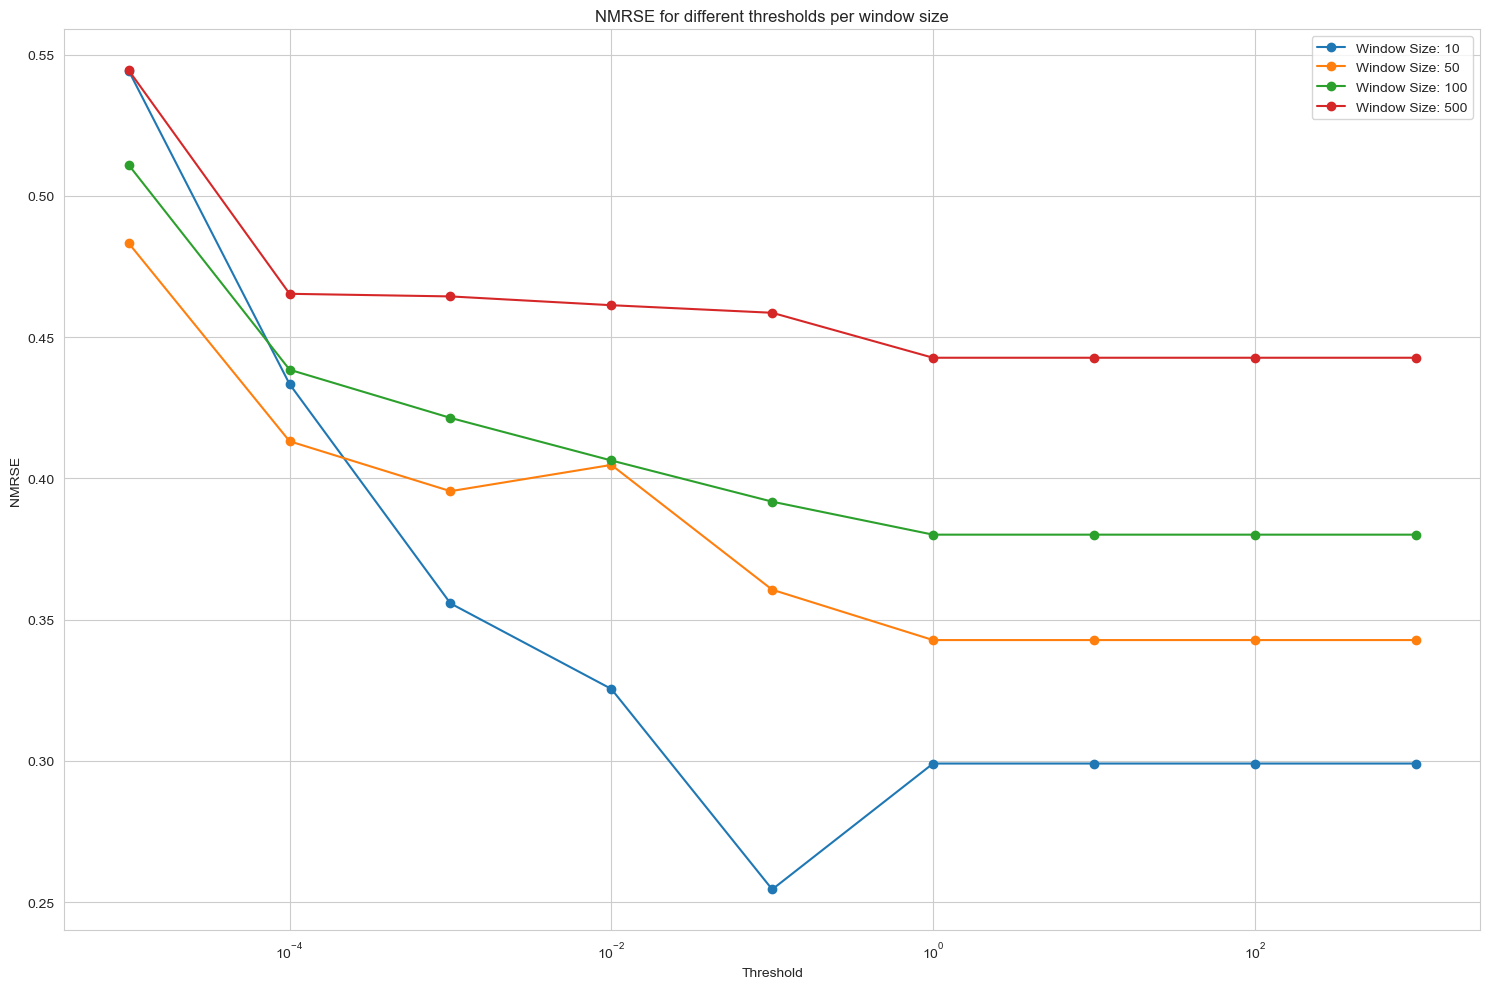

In [60]:
# Let's plot the NMRSE for the different thresholds per window size
# The results are in an array of dictionaries, so we need to extract the data into a format that can be plotted
# We will create a dictionary where the keys are the window sizes, and the values are the NMRSEs for the different thresholds

window_scores_dict = {window_size: [] for window_size in window_sizes}

for score in fourier_window_scores:
    window_size = score['window_size']
    threshold = score['threshold']
    nmrse = score['nmrse']

    window_scores_dict[window_size].append({'threshold': threshold, 'nmrse': nmrse})

# Now we can plot the NMRSE for the different thresholds per window size
plt.figure(figsize=(15, 10))

for window_size, scores in window_scores_dict.items():
    thresholds = [score['threshold'] for score in scores]
    nmrses = [score['nmrse'] for score in scores]

    plt.plot(thresholds, nmrses, marker='o', label=f'Window Size: {window_size}')

plt.xlabel('Threshold')
plt.ylabel('NMRSE')
plt.xscale('log')
plt.legend()

plt.title('NMRSE for different thresholds per window size')

plt.tight_layout()
plt.show()

In [61]:
# Get the best threshold and window size
best_threshold_window = fourier_window_scores[np.argmin([score['nmrse'] for score in fourier_window_scores])]
best_threshold = best_threshold_window['threshold']
best_window_size = best_threshold_window['window_size']

print(f'Best Threshold: {best_threshold}, Best Window Size: {best_window_size}')

Best Threshold: 0.1, Best Window Size: 10


In [63]:
# Now let's train the best version of each of these preprocessing methods and evaluate the performance

window_pickle = 'threeHierarchyESN_har70_window.pkl'

X_train_windowed, y_train_windowed = data_preprocessor.buffered_windows(best_window_size, X_train_scaled,
                                                                        y_train_encoded)
X_val_windowed, y_val_windowed = data_preprocessor.buffered_windows(best_window_size, X_val_scaled, y_val_encoded)
X_test_windowed, y_test_windowed = data_preprocessor.buffered_windows(best_window_size, X_test_scaled, y_test_encoded)

if run_window_optimisation or not os.path.exists(window_pickle):

    input_weights_1 = generate_input_weights(best_n_neurons_1, X_train_windowed.shape[1], best_density_1,
                                             best_weight_distribution_1,
                                             seed=42)
    input_weights_2 = generate_input_weights(best_n_neurons_2, X_train_windowed.shape[1], best_density_2,
                                             best_weight_distribution_2,
                                             seed=42)
    input_weights_3 = generate_input_weights(best_n_neurons_3, X_train_windowed.shape[1], best_density_3,
                                             best_weight_distribution_3,
                                             seed=42)

    esn = ThreeHierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                            gamma_1=best_gamma_1,
                            W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1, sparsity_1=best_sparsity_1,
                            leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                            gamma_2=best_gamma_2,
                            W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2, sparsity_2=best_sparsity_2,
                            leakage_rate_3=best_leakage_rate_3, spectral_radius_3=best_spectral_radius_3,
                            gamma_3=best_gamma_3,
                            W_in_3=input_weights_3, n_neurons_3=best_n_neurons_3, sparsity_3=best_sparsity_3,
                            class_weights=class_weights, seed=42)

    # Fit the ESN
    esn.fit(X_train_windowed, y_train_windowed, x_val=X_val_windowed, y_val=y_val_windowed)

    # Let's also pickle the best ESN for future use
    with open(window_pickle, 'wb') as f:
        pickle.dump(esn, f)

else:
    # Load the ESN from the pickle file
    with open(window_pickle, 'rb') as f:
        esn = pickle.load(f)

# Predict the output
y_pred = esn.forward(X_test_windowed)

# Decode the output
# We need to decode the output as it is one-hot encoded
# But the windowed data is in the shape of (n_samples//window_size, n_classes * window_size), we need to reshape it to (n_samples, n_classes)
y_test_resized = y_test_windowed.reshape(-1, y_test_windowed.shape[-1] // best_window_size)
y_pred_resized = y_pred.reshape(-1, y_pred.shape[-1] // best_window_size)

y_test_decoded_window = data_preparation.get_encoder().inverse_transform(y_test_resized)
y_pred_decoded_window = data_preparation.get_encoder().inverse_transform(y_pred_resized)

# Calculate the nmrse
nmrse = np.sqrt(mean_squared_error(y_test_decoded_window, y_pred_decoded_window)) / (
        y_pred_decoded_window.max() - y_pred_decoded_window.min())

print(f'Windowed NMRSE: {nmrse}')

Buffered data shape: (135765, 60), (135765, 70)
Buffered data shape: (33941, 60), (33941, 70)
Buffered data shape: (56255, 60), (56255, 70)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 0.6674647243532564, spectral_radius_3: 0.13303480091978592, gamma_3: 0.4754788170338825, n_neurons_3: 117
Step: 0/135765
Step: 10000/135765
Step: 20000/135765
Step: 30000/135765
Step: 40000/135765
Step: 50000/135765
Step: 60000/135765
Step: 70000/135765
Step: 80000/135765
Step: 90000/135765
Step: 100000/135765
Step: 110000/135765
Step: 120000/135765
Step: 5765/135765
Shape of previous_states: (135765, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, fitting readout layer with validation data...
Step: 0/

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.52519e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.0005994842503189409, Score: 0.07296276230966033


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.2548e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.004641588833612777, Score: 0.13782243340682584


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.21027e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.03593813663804626, Score: 0.1712835930328869
Alpha: 0.2782559402207126, Score: 0.2045671029673553
Alpha: 2.154434690031882, Score: 0.2183227764276809
Alpha: 16.681005372000556, Score: 0.20453787552689043
Alpha: 129.15496650148827, Score: 0.15093190496704867
Alpha: 1000.0, Score: 0.08992717425224461
Best alpha: 2.154434690031882
Readout layer fitted.
Step: 0/56255
Step: 10000/56255
Step: 20000/56255
Step: 30000/56255
Step: 40000/56255
Step: 6255/56255
Shape of previous_states: (56255, 500)
Windowed NMRSE: 0.3010566392047365


In [64]:
ema_pickle = 'threeHierarchyESN_har70_ema.pkl'

X_train_ema, y_train_ema = data_preprocessor.exponential_moving_average(best_alpha, X_train_scaled, y_train_encoded)
X_val_ema, y_val_ema = data_preprocessor.exponential_moving_average(best_alpha, X_val_scaled, y_val_encoded)
X_test_ema, y_test_ema = data_preprocessor.exponential_moving_average(best_alpha, X_test_scaled, y_test_encoded)

if run_emas_optimisation or not os.path.exists(ema_pickle):

    input_weights_1 = generate_input_weights(best_n_neurons_1, n_features, best_density_1, best_weight_distribution_1,
                                             seed=42)
    input_weights_2 = generate_input_weights(best_n_neurons_2, n_features, best_density_2, best_weight_distribution_2,
                                             seed=42)
    input_weights_3 = generate_input_weights(best_n_neurons_3, n_features, best_density_3, best_weight_distribution_3,
                                             seed=42)

    esn = ThreeHierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                            gamma_1=best_gamma_1,
                            W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1, sparsity_1=best_sparsity_1,
                            leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                            gamma_2=best_gamma_2,
                            W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2, sparsity_2=best_sparsity_2,
                            leakage_rate_3=best_leakage_rate_3, spectral_radius_3=best_spectral_radius_3,
                            gamma_3=best_gamma_3,
                            W_in_3=input_weights_3, n_neurons_3=best_n_neurons_3, sparsity_3=best_sparsity_3,
                            class_weights=class_weights, seed=42)

    # Fit the ESN
    esn.fit(X_train_ema, y_train_ema, x_val=X_val_ema, y_val=y_val_ema)

    # Let's also pickle the best ESN for future use
    with open(ema_pickle, 'wb') as f:
        pickle.dump(esn, f)

else:
    # Load the ESN from the pickle file
    with open(ema_pickle, 'rb') as f:
        esn = pickle.load(f)

# Predict the output
y_pred = esn.forward(X_test_ema)

# Decode the output
y_test_decoded_ema = data_preparation.get_encoder().inverse_transform(y_test_ema)
y_pred_decoded_ema = data_preparation.get_encoder().inverse_transform(y_pred)

# Calculate the nmrse
nmrse = np.sqrt(mean_squared_error(y_test_decoded_ema, y_pred_decoded_ema)) / (
        y_pred_decoded_ema.max() - y_pred_decoded_ema.min())

print(f'EMA NMRSE: {nmrse}')

Smoothed data shape: (1357646, 6), (1357646, 7)
Smoothed data shape: (339404, 6), (339404, 7)
Smoothed data shape: (562547, 6), (562547, 7)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 0.6674647243532564, spectral_radius_3: 0.13303480091978592, gamma_3: 0.4754788170338825, n_neurons_3: 117
Step: 0/1357646
Step: 10000/1357646
Step: 20000/1357646
Step: 30000/1357646
Step: 40000/1357646
Step: 50000/1357646
Step: 60000/1357646
Step: 70000/1357646
Step: 80000/1357646
Step: 90000/1357646
Step: 100000/1357646
Step: 110000/1357646
Step: 120000/1357646
Step: 130000/1357646
Step: 140000/1357646
Step: 150000/1357646
Step: 160000/1357646
Step: 170000/1357646
Step: 180000/1357646
Step: 190000/1357646
Step: 200000/1357646
Step: 21

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.94396e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.2329485012571257
Alpha: 16.681005372000556, Score: 0.1697802388438637
Alpha: 129.15496650148827, Score: 0.1184570848533101
Alpha: 1000.0, Score: 0.0930804662609366
Best alpha: 0.03593813663804626
Readout layer fitted.
Step: 0/562547
Step: 10000/562547
Step: 20000/562547
Step: 30000/562547
Step: 40000/562547
Step: 50000/562547
Step: 60000/562547
Step: 70000/562547
Step: 80000/562547
Step: 90000/562547
Step: 100000/562547
Step: 110000/562547
Step: 120000/562547
Step: 130000/562547
Step: 140000/562547
Step: 150000/562547
Step: 160000/562547
Step: 170000/562547
Step: 180000/562547
Step: 190000/562547
Step: 200000/562547
Step: 210000/562547
Step: 220000/562547
Step: 230000/562547
Step: 240000/562547
Step: 250000/562547
Step: 260000/562547
Step: 270000/562547
Step: 280000/562547
Step: 290000/562547
Step: 300000/562547
Step: 310000/562547
Step: 320000/562547
Step: 330000/562547
Step: 340000/562547
Step: 350000/562547
Step: 360000/562547
Step: 370000/562547
S

In [65]:
fourier_pickle = 'threeHierarchyESN_har70_fourier.pkl'

X_train_fourier = data_preprocessor.fourier_smoothing(X_train_scaled, best_threshold)
X_val_fourier = data_preprocessor.fourier_smoothing(X_val_scaled, best_threshold)
X_test_fourier = data_preprocessor.fourier_smoothing(X_test_scaled, best_threshold)

if run_fourier_optimisation or not os.path.exists(fourier_pickle):
    input_weights_1 = generate_input_weights(best_n_neurons_1, n_features, best_density_1, best_weight_distribution_1,
                                             seed=42)
    input_weights_2 = generate_input_weights(best_n_neurons_2, n_features, best_density_2, best_weight_distribution_2,
                                             seed=42)
    input_weights_3 = generate_input_weights(best_n_neurons_3, n_features, best_density_3, best_weight_distribution_3,
                                             seed=42)

    esn = ThreeHierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                            gamma_1=best_gamma_1,
                            W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1, sparsity_1=best_sparsity_1,
                            leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                            gamma_2=best_gamma_2,
                            W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2, sparsity_2=best_sparsity_2,
                            leakage_rate_3=best_leakage_rate_3, spectral_radius_3=best_spectral_radius_3,
                            gamma_3=best_gamma_3,
                            W_in_3=input_weights_3, n_neurons_3=best_n_neurons_3, sparsity_3=best_sparsity_3,
                            class_weights=class_weights, seed=42)

    # Fit the ESN
    esn.fit(X_train_fourier, y_train_encoded, x_val=X_val_fourier, y_val=y_val_encoded)

    # Let's also pickle the best ESN for future use
    with open(fourier_pickle, 'wb') as f:
        pickle.dump(esn, f)

else:
    # Load the ESN from the pickle file
    with open(fourier_pickle, 'rb') as f:
        esn = pickle.load(f)

# Predict the output
y_pred = esn.forward(X_test_fourier)

# Decode the output
y_test_decoded_fourier = data_preparation.get_encoder().inverse_transform(y_test_encoded)
y_pred_decoded_fourier = data_preparation.get_encoder().inverse_transform(y_pred)

# Calculate the nmrse
nmrse = np.sqrt(mean_squared_error(y_test_decoded_fourier, y_pred_decoded_fourier)) / (
        y_pred_decoded_fourier.max() - y_pred_decoded_fourier.min())

print(f'Fourier NMRSE: {nmrse}')


Fourier data shape: (1357646, 6)
Fourier data shape: (339404, 6)
Fourier data shape: (562547, 6)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 0.6674647243532564, spectral_radius_3: 0.13303480091978592, gamma_3: 0.4754788170338825, n_neurons_3: 117
Step: 0/1357646
Step: 10000/1357646
Step: 20000/1357646
Step: 30000/1357646
Step: 40000/1357646
Step: 50000/1357646
Step: 60000/1357646
Step: 70000/1357646
Step: 80000/1357646
Step: 90000/1357646
Step: 100000/1357646
Step: 110000/1357646
Step: 120000/1357646
Step: 130000/1357646
Step: 140000/1357646
Step: 150000/1357646
Step: 160000/1357646
Step: 170000/1357646
Step: 180000/1357646
Step: 190000/1357646
Step: 200000/1357646
Step: 210000/1357646
Step: 220000/1357646
Step: 230

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.91326e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.21175592465761012
Alpha: 16.681005372000556, Score: 0.1491060453188872
Alpha: 129.15496650148827, Score: 0.10979682275763092
Alpha: 1000.0, Score: 0.09049889863777946
Best alpha: 0.03593813663804626
Readout layer fitted.
Step: 0/562547
Step: 10000/562547
Step: 20000/562547
Step: 30000/562547
Step: 40000/562547
Step: 50000/562547
Step: 60000/562547
Step: 70000/562547
Step: 80000/562547
Step: 90000/562547
Step: 100000/562547
Step: 110000/562547
Step: 120000/562547
Step: 130000/562547
Step: 140000/562547
Step: 150000/562547
Step: 160000/562547
Step: 170000/562547
Step: 180000/562547
Step: 190000/562547
Step: 200000/562547
Step: 210000/562547
Step: 220000/562547
Step: 230000/562547
Step: 240000/562547
Step: 250000/562547
Step: 260000/562547
Step: 270000/562547
Step: 280000/562547
Step: 290000/562547
Step: 300000/562547
Step: 310000/562547
Step: 320000/562547
Step: 330000/562547
Step: 340000/562547
Step: 350000/562547
Step: 360000/562547
Step: 370000/56254

In [67]:
fourier_window_pickle = 'threeHierarchyESN_har70_fourier_window.pkl'

pipeline_steps = ['fourier_smoothing', 'buffered_windows']

pipeline_params = [best_threshold, best_window_size]

x_train_windowed_fourier, y_train_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_train_scaled,
                                                                                y_train_encoded, pipeline_params)

x_val_windowed_fourier, y_val_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_val_scaled,
                                                                            y_val_encoded, pipeline_params)

x_test_windowed_fourier, y_test_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_test_scaled,
                                                                              y_test_encoded, pipeline_params)

if run_fourier_window_optimisation or not os.path.exists(fourier_window_pickle):

    input_weights_1 = generate_input_weights(best_n_neurons_1, x_train_windowed_fourier.shape[1], best_density_1,
                                             best_weight_distribution_1,
                                             seed=42)
    input_weights_2 = generate_input_weights(best_n_neurons_2, x_train_windowed_fourier.shape[1], best_density_2,
                                             best_weight_distribution_2,
                                             seed=42)
    input_weights_3 = generate_input_weights(best_n_neurons_3, x_train_windowed_fourier.shape[1], best_density_3,
                                                best_weight_distribution_3,
                                                seed=42)

    esn = ThreeHierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                            gamma_1=best_gamma_1,
                            W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1, sparsity_1=best_sparsity_1,
                            leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                            gamma_2=best_gamma_2,
                            W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2, sparsity_2=best_sparsity_2,
                            leakage_rate_3=best_leakage_rate_3, spectral_radius_3=best_spectral_radius_3,
                            gamma_3=best_gamma_3,
                            W_in_3=input_weights_3, n_neurons_3=best_n_neurons_3, sparsity_3=best_sparsity_3,
                            class_weights=class_weights, seed=42)

    # Fit the ESN
    esn.fit(x_train_windowed_fourier, y_train_windowed_fourier, x_val=x_val_windowed_fourier,
            y_val=y_val_windowed_fourier)

    # Let's also pickle the best ESN for future use
    with open(fourier_window_pickle, 'wb') as f:
        pickle.dump(esn, f)

else:
    # Load the ESN from the pickle file
    with open(fourier_window_pickle, 'rb') as f:
        esn = pickle.load(f)

# Predict the output
y_pred = esn.forward(x_test_windowed_fourier)

# Decode the output
# We need to decode the output as it is one-hot encoded
# But the windowed data is in the shape of (n_samples//window_size, n_classes * window_size), we need to reshape it to (n_samples, n_classes)
y_test_resized = y_test_windowed_fourier.reshape(-1, y_test_windowed_fourier.shape[-1] // best_window_size)
y_pred_resized = y_pred.reshape(-1, y_pred.shape[-1] // best_window_size)

y_test_decoded_fourier_window = data_preparation.get_encoder().inverse_transform(y_test_resized)
y_pred_decoded_fourier_window = data_preparation.get_encoder().inverse_transform(y_pred_resized)

# Calculate the nmrse
nmrse = np.sqrt(mean_squared_error(y_test_decoded_fourier_window, y_pred_decoded_fourier_window)) / (
        y_pred_decoded_fourier_window.max() - y_pred_decoded_fourier_window.min())

print(f'Fourier Windowed NMRSE: {nmrse}')

Fourier data shape: (1357646, 6)
Buffered data shape: (135765, 60), (135765, 70)
Fourier data shape: (339404, 6)
Buffered data shape: (33941, 60), (33941, 70)
Fourier data shape: (562547, 6)
Buffered data shape: (56255, 60), (56255, 70)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9721196221438391, spectral_radius_1: 0.9048794207552125, gamma_1: 0.8008014185674769, n_neurons_1: 350, leakage_rate_2: 0.5610244981317168, spectral_radius_2: 0.0532568977054132, gamma_2: 0.1906404433300536, n_neurons_2: 33 and leakage_rate_3: 0.6674647243532564, spectral_radius_3: 0.13303480091978592, gamma_3: 0.4754788170338825, n_neurons_3: 117
Step: 0/135765
Step: 10000/135765
Step: 20000/135765
Step: 30000/135765
Step: 40000/135765
Step: 50000/135765
Step: 60000/135765
Step: 70000/135765
Step: 80000/135765
Step: 90000/135765
Step: 100000/135765
Step: 110000/135765
Step: 120000/135765
Step: 5765/135765
Shape of previous_states: (135765, 500)
Reservoir state computed, fitting 

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.17356e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.03593813663804626, Score: 0.22183538920078777
Alpha: 0.2782559402207126, Score: 0.21683303042065707
Alpha: 2.154434690031882, Score: 0.21519337196788765
Alpha: 16.681005372000556, Score: 0.17839534673186389
Alpha: 129.15496650148827, Score: 0.119747226525772
Alpha: 1000.0, Score: 0.07851425991822117
Best alpha: 0.004641588833612777
Readout layer fitted.
Step: 0/56255
Step: 10000/56255
Step: 20000/56255
Step: 30000/56255
Step: 40000/56255
Step: 6255/56255
Shape of previous_states: (56255, 500)
Fourier Windowed NMRSE: 0.2545119234976339


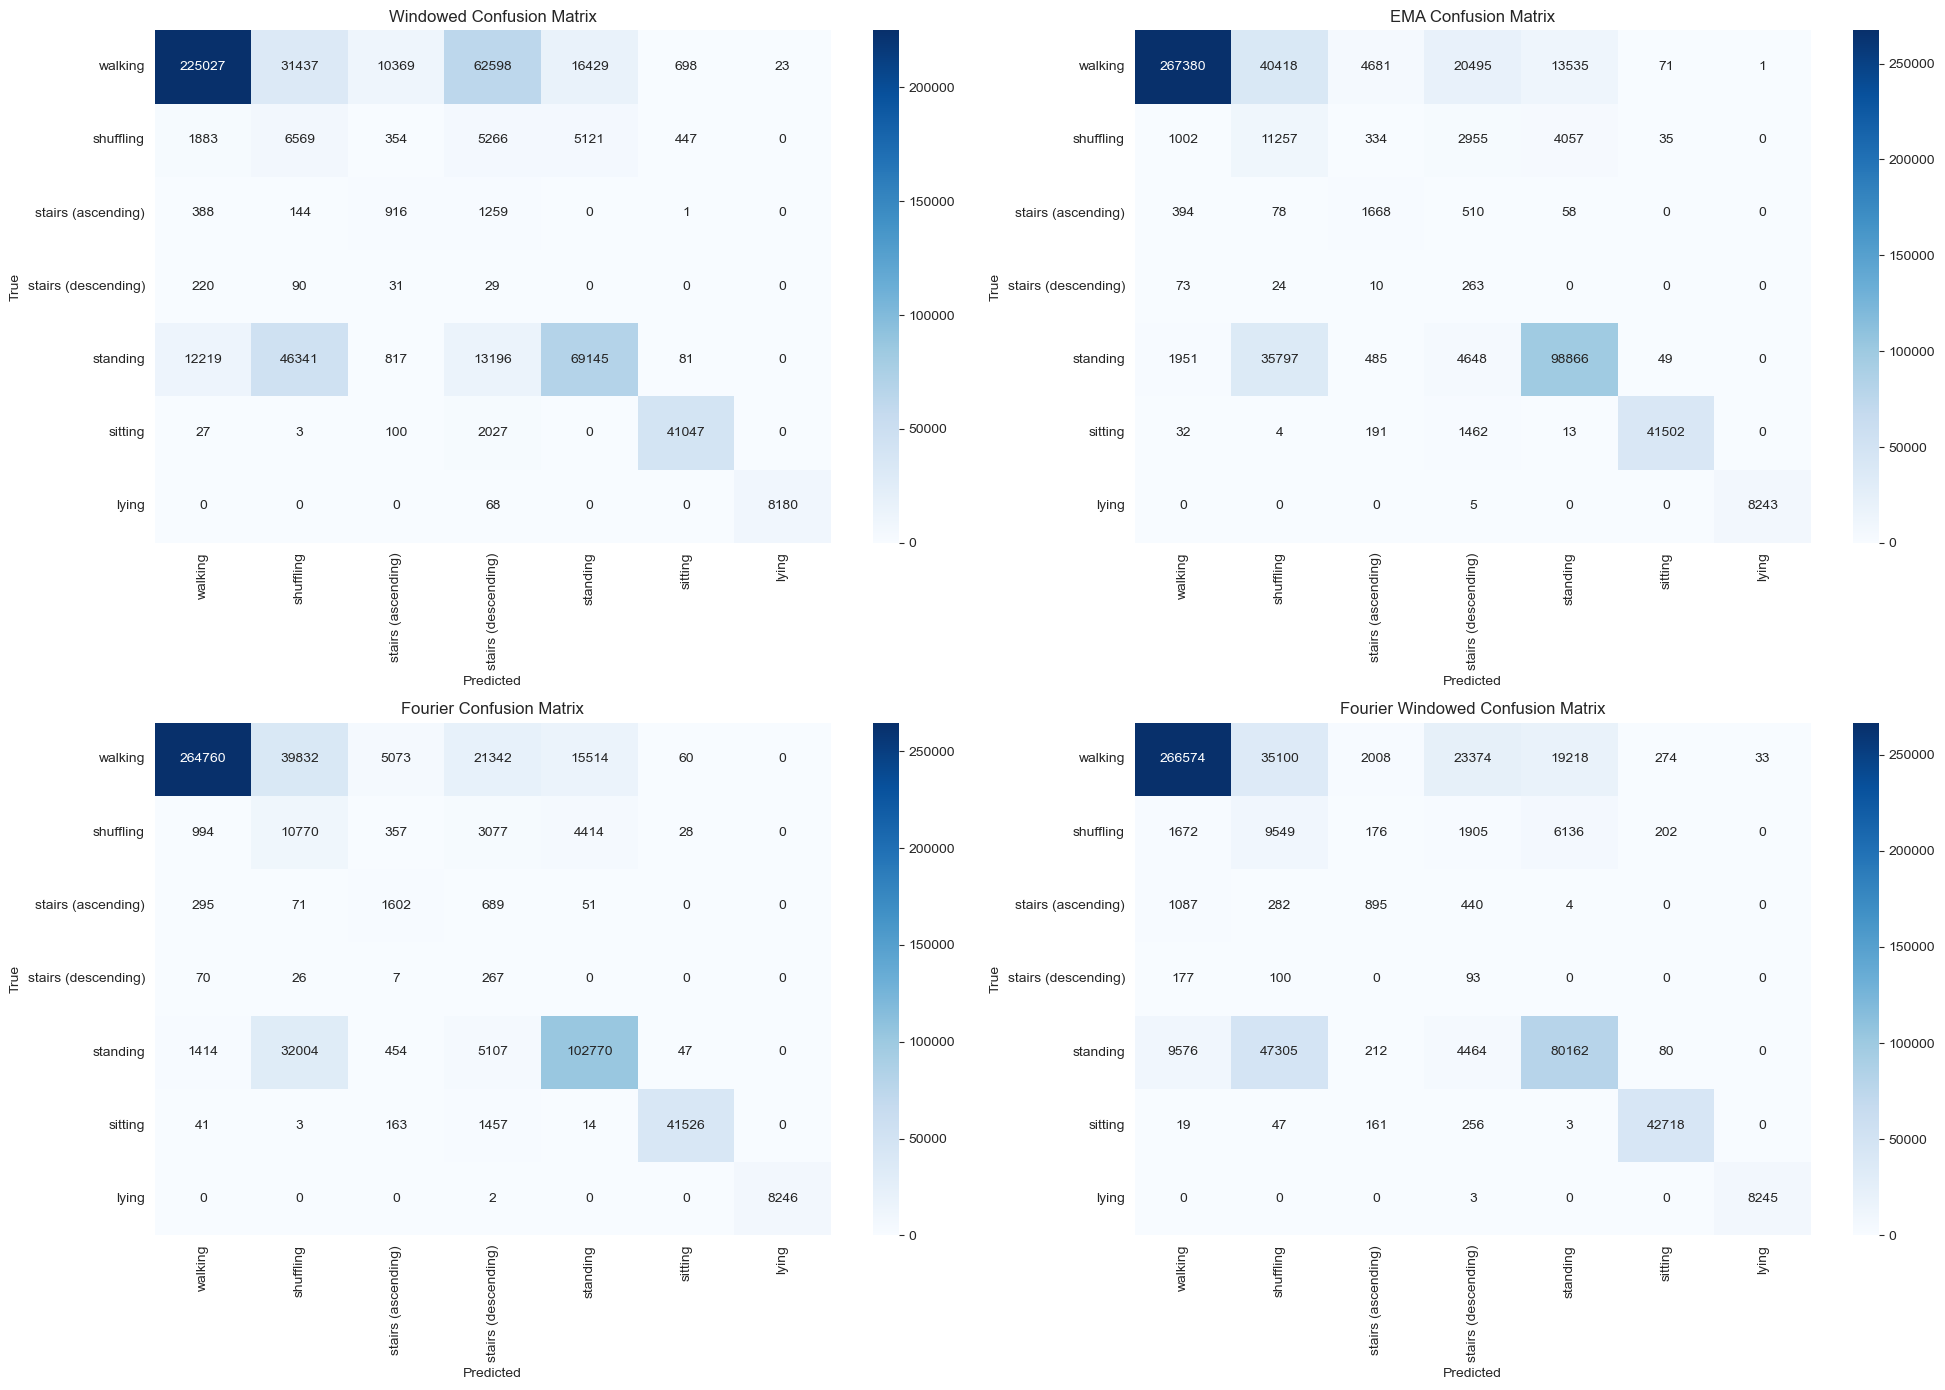

In [68]:
# Let's now plot the confusion matrix for the best version of each of these preprocessing methods
plt.figure(figsize=(20, 14))

conf_matrix_windowed = confusion_matrix(y_test_decoded_window, y_pred_decoded_window)
conf_matrix_ema = confusion_matrix(y_test_decoded_ema, y_pred_decoded_ema)
conf_matrix_fourier = confusion_matrix(y_test_decoded_fourier, y_pred_decoded_fourier)
conf_matrix_fourier_window = confusion_matrix(y_test_decoded_fourier_window, y_pred_decoded_fourier_window)

plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix_windowed, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Windowed Confusion Matrix')

plt.subplot(2, 2, 2)
sns.heatmap(conf_matrix_ema, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('EMA Confusion Matrix')

plt.subplot(2, 2, 3)
sns.heatmap(conf_matrix_fourier, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Fourier Confusion Matrix')

plt.subplot(2, 2, 4)
sns.heatmap(conf_matrix_fourier_window, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Fourier Windowed Confusion Matrix')

plt.tight_layout()
plt.show()

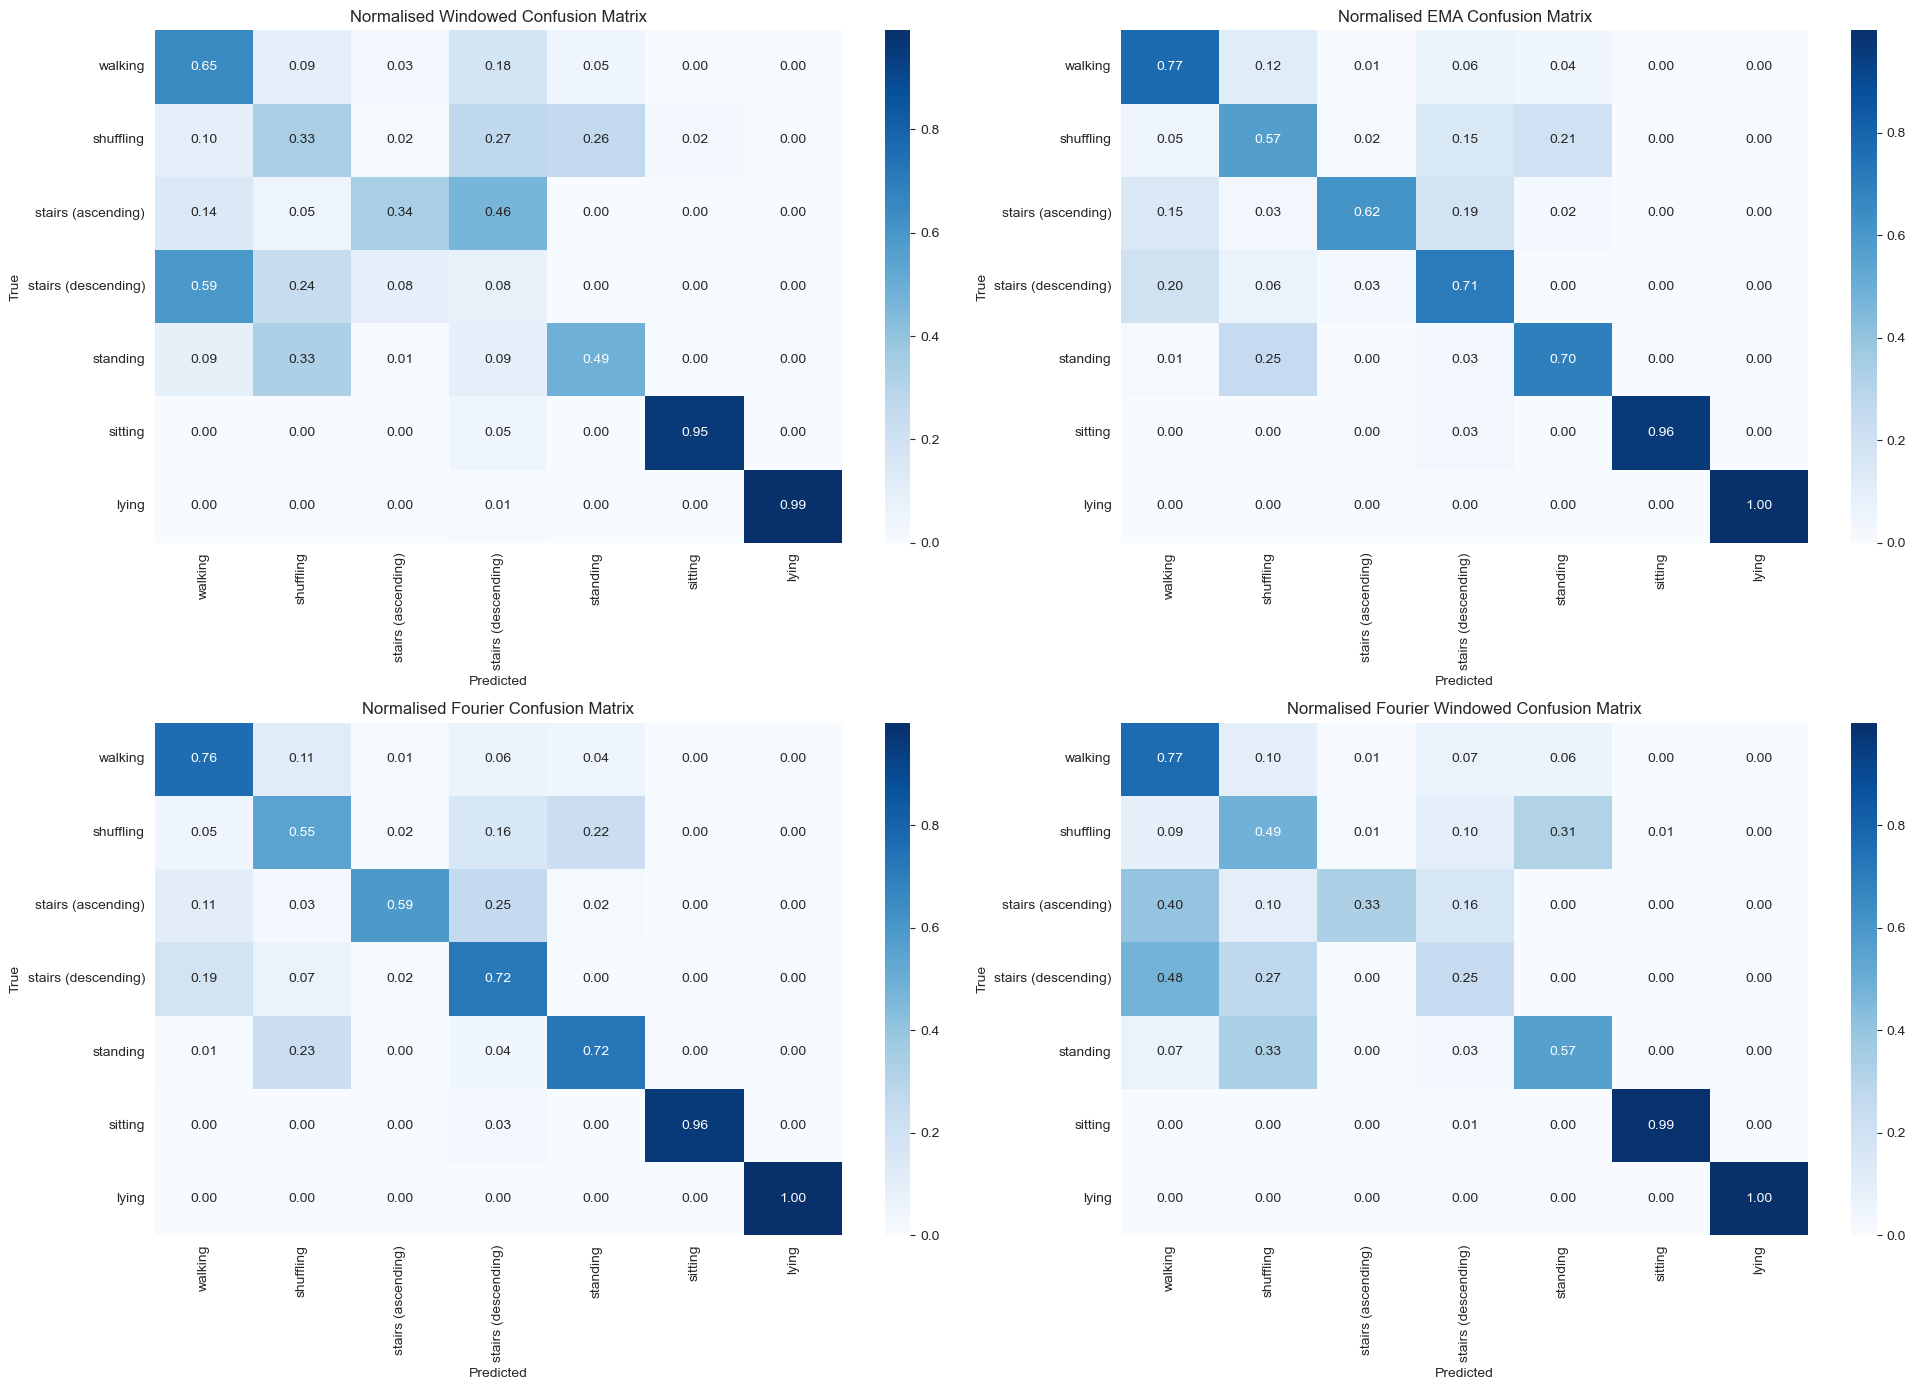

In [69]:
# Let's plot the normalised confusion matrix for the best version of each of these preprocessing methods

conf_matrix_windowed_norm = conf_matrix_windowed / conf_matrix_windowed.sum(axis=1)[:, np.newaxis]
conf_matrix_ema_norm = conf_matrix_ema / conf_matrix_ema.sum(axis=1)[:, np.newaxis]
conf_matrix_fourier_norm = conf_matrix_fourier / conf_matrix_fourier.sum(axis=1)[:, np.newaxis]
conf_matrix_fourier_window_norm = conf_matrix_fourier_window / conf_matrix_fourier_window.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 14))

plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix_windowed_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Windowed Confusion Matrix')

plt.subplot(2, 2, 2)
sns.heatmap(conf_matrix_ema_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised EMA Confusion Matrix')

plt.subplot(2, 2, 3)
sns.heatmap(conf_matrix_fourier_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Fourier Confusion Matrix')

plt.subplot(2, 2, 4)
sns.heatmap(conf_matrix_fourier_window_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Fourier Windowed Confusion Matrix')

plt.tight_layout()
plt.show()

In [70]:
# Let's print the classification report for the best version of each of these preprocessing methods

report_windowed = classification_report(y_test_decoded_window, y_pred_decoded_window, target_names=labels)
report_ema = classification_report(y_test_decoded_ema, y_pred_decoded_ema, target_names=labels)
report_fourier = classification_report(y_test_decoded_fourier, y_pred_decoded_fourier, target_names=labels)
report_fourier_windowed = classification_report(y_test_decoded_fourier_window, y_pred_decoded_fourier_window,
                                                target_names=labels)

print('Windowed Classification Report')
print(report_windowed)
print('-' * 100)

print('EMA Classification Report')
print(report_ema)
print('-' * 100)

print('Fourier Classification Report')
print(report_fourier)
print('-' * 100)

print('Fourier Windowed Classification Report')
print(report_fourier_windowed)

Windowed Classification Report
                     precision    recall  f1-score   support

            walking       0.94      0.65      0.77    346581
          shuffling       0.08      0.33      0.13     19640
 stairs (ascending)       0.07      0.34      0.12      2708
stairs (descending)       0.00      0.08      0.00       370
           standing       0.76      0.49      0.59    141799
            sitting       0.97      0.95      0.96     43204
              lying       1.00      0.99      0.99      8248

           accuracy                           0.62    562550
          macro avg       0.55      0.55      0.51    562550
       weighted avg       0.86      0.62      0.72    562550

----------------------------------------------------------------------------------------------------
EMA Classification Report
                     precision    recall  f1-score   support

            walking       0.99      0.77      0.87    346581
          shuffling       0.13      0.57     